# Model evaluation

In [ ]:
import pandas as pd

X_train = pd.read_csv('dataset/training_datasetDEF.csv')

df = pd.read_csv('dataset/train_label_column.csv')

df["Label"] = df["Label"].map({"good": 0, "bad": 1})
y_train = df["Label"]

X_test = pd.read_csv('dataset/testing_revamped2.csv')
y_test_df = pd.read_csv('dataset/testing_labels.csv')
y_test = y_test_df["Label"]

## 1. Random Forest

First let's analyse the results of using default hyperparameter values.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# probability for the positive class (1)
y_prob = model.predict_proba(X_test)[:, 1]  

print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"F1 Score: {f1:.4f}")

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     43820
           1       0.89      0.89      0.89     43711

    accuracy                           0.89     87531
   macro avg       0.89      0.89      0.89     87531
weighted avg       0.89      0.89      0.89     87531

ROC-AUC Score: 0.9613
F1 Score: 0.8937


Now let's tune the hyperparameters.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
import numpy as np
from tqdm import tqdm

rfc = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': [80, 100, 150],  
    'max_depth': [None, 10, 20, 30, 50],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 5],  
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']  
}

skf = StratifiedKFold(n_splits=5)

random_search = RandomizedSearchCV(
    estimator=rfc,
    param_distributions=param_dist,
    n_iter=50, 
    cv=skf,
    random_state=42,
    verbose=3, 
    n_jobs=-1,  
    scoring='f1'
)

random_search.fit(X_train, y_train)

print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'criterion': 'gini'}
Best score: 0.8896464929248333


In [ ]:
from sklearn.ensemble import RandomForestClassifier
# best parameters
model = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='log2',
    max_depth=50,
    criterion='gini'
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

F1 Score: 0.8938


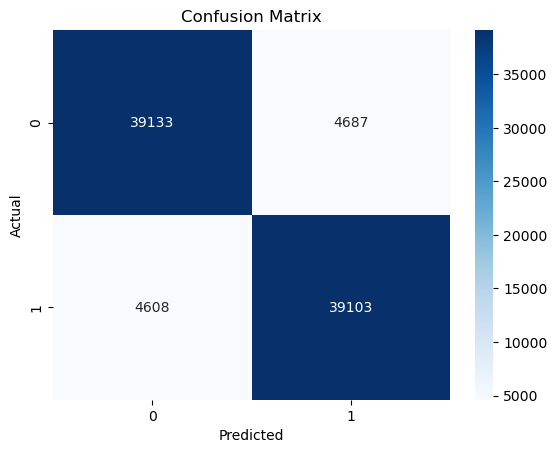

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ( f1_score, confusion_matrix, classification_report )
import seaborn as sns
import matplotlib.pyplot as plt

f1 = f1_score(y_test, y_pred, average='weighted')

print(f"F1 Score: {f1:.4f}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["good", "bad"]))


Classification Report:
              precision    recall  f1-score   support

        good       0.89      0.89      0.89     43820
         bad       0.89      0.89      0.89     43711

    accuracy                           0.89     87531
   macro avg       0.89      0.89      0.89     87531
weighted avg       0.89      0.89      0.89     87531



In [ ]:
from joblib import dump
dump(model, 'random_forest_model.joblib')

['random_forest_model.joblib']

## 2. XGBoost

Default parameters model:

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score

xgb_model = XGBClassifier(random_state=42) 
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

f1 = f1_score(y_test, y_pred_xgb)

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("F1 Score:", f1)
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_xgb))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86     43820
           1       0.86      0.86      0.86     43711

    accuracy                           0.86     87531
   macro avg       0.86      0.86      0.86     87531
weighted avg       0.86      0.86      0.86     87531

F1 Score: 0.8605560332473489
ROC-AUC Score: 0.9416801502474643


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(random_state=42, n_jobs=-1, objective='binary:logistic')

param_dist = {
    'n_estimators': [150, 200, 250],  
    'max_depth': [6, 7, 8, 9],        
    'min_child_weight': [3, 5, 7],    
    'learning_rate': [0.1, 0.15, 0.2], 
    'subsample': [0.8, 0.9, 1.0], 
    'colsample_bytree': [0.8, 0.9, 1.0],  
    'gamma': [0.1, 0.2, 0.3],        
}

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=75,
    cv=skf,
    scoring='f1',
    verbose=3,
    n_jobs=-1,
    random_state=42,
)

# progress tracking
print("Starting RandomizedSearchCV...")
with tqdm(total=random_search.n_iter * skf.get_n_splits()) as pbar:
    def on_progress(*args, **kwargs):
        pbar.update(1)

    random_search.fit(X_train, y_train)

print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")


Starting RandomizedSearchCV...


  0%|                                                                                                                              | 0/225 [00:00<?, ?it/s]

Fitting 3 folds for each of 75 candidates, totalling 225 fits


  0%|                                                                                                                              | 0/225 [16:06<?, ?it/s]

Best parameters: {'subsample': 0.9, 'n_estimators': 250, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.15, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best score: 0.875869764176349


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

best_params = {
    'subsample': 0.9,
    'n_estimators': 250,
    'min_child_weight': 3,
    'max_depth': 9,
    'learning_rate': 0.15,
    'gamma': 0.1,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'eval_metric': 'logloss'
}

xgb_model = XGBClassifier(**best_params)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

f1 = f1_score(y_test, y_pred_xgb)

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("F1 Score:", f1)
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_xgb))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     43820
           1       0.88      0.87      0.88     43711

    accuracy                           0.88     87531
   macro avg       0.88      0.88      0.88     87531
weighted avg       0.88      0.88      0.88     87531

F1 Score: 0.8771523026768906
ROC-AUC Score: 0.9546865719542221


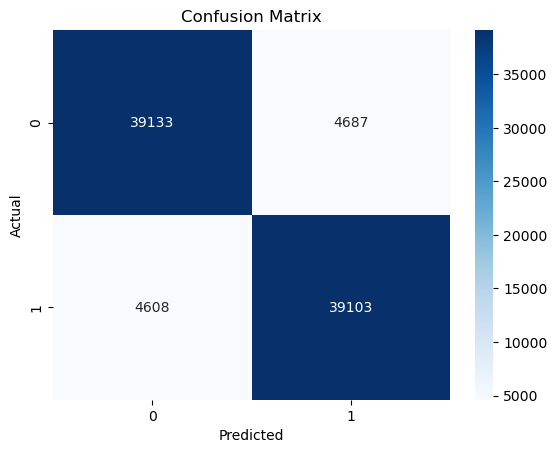

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=xgb_model.classes_, yticklabels=xgb_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from joblib import dump
dump(xgb_model, 'XGBoost_model.joblib')

['XGBoost_model.joblib']

## 3. LightGBM

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report

lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

y_pred = lgb_model.predict(X_test)

[LightGBM] [Info] Number of positive: 175115, number of negative: 175006
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.158064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1974
[LightGBM] [Info] Number of data points in the train set: 350121, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500156 -> initscore=0.000623
[LightGBM] [Info] Start training from score 0.000623



Classification Report:
              precision    recall  f1-score   support

        good       0.84      0.85      0.85     43820
         bad       0.85      0.84      0.85     43711

    accuracy                           0.85     87531
   macro avg       0.85      0.85      0.85     87531
weighted avg       0.85      0.85      0.85     87531


ROC-AUC Score: 0.9318

F1 Score: 0.8466


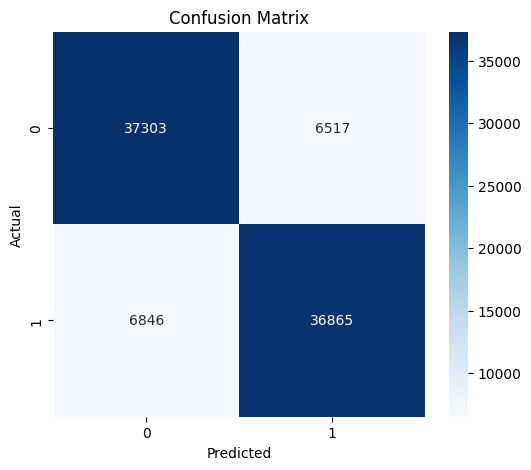

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_prob = lgb_model.predict_proba(X_test)[:, 1]  # probabilities for ROC-AUC

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["good", "bad"]))

roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

f1 = f1_score(y_test, y_pred)
print(f"\nF1 Score: {f1:.4f}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lgb_model.classes_, yticklabels=lgb_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Now let's tune the hyperparameters.

In [ ]:
import optuna
import lightgbm as lgb
from sklearn.metrics import f1_score

def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_error', 
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'min_gain_to_split': trial.suggest_loguniform('min_gain_to_split', 0.01, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'boosting_type': 'gbdt',
        'random_state': 42
    }

    model = lgb.LGBMClassifier(**param)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='binary')

    return f1

study = optuna.create_study(direction='maximize')  # 'maximize' for F1-score
study.optimize(objective, n_trials=150)  # Number of trials to run

print("Best parameters:", study.best_params)
print("Best F1-score:", study.best_value)

C:\Users\ansru\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-02-16 22:14:15,084] A new study created in memory with name: no-name-6e1d69ec-b5b6-4212-9d3a-6960ba7a1c04
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_gain_to_spli

[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] feature_fraction is set=0.8771162108092934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8771162108092934
[LightGBM] [Warning] min_gain_to_split is set=0.022188604857215816, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.022188604857215816
[LightGBM] [Warning] bagging_fraction is set=0.9351564586475518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9351564586475518
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] feature_fraction is set=0.8771162108092934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8771162108092934
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:14:25,674] Trial 0 finished with value: 0.8232464468611542 and parameters: {'learning_rate': 0.018857593555189737, 'num_leaves': 39, 'max_depth': 14, 'min_data_in_leaf': 41, 'min_gain_to_split': 0.022188604857215816, 'feature_fraction': 0.8771162108092934, 'bagging_fraction': 0.9351564586475518, 'bagging_freq': 8}. Best is trial 0 with value: 0.8232464468611542.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.9734620076988733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9734620076988733
[LightGBM] [Warning] min_gain_to_split is set=0.017649154946732967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.017649154946732967
[LightGBM] [Warning] bagging_fraction is set=0.6901958227447681, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6901958227447681
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.9734620076988733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9734620076988733
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:14:32,592] Trial 1 finished with value: 0.7895588971847227 and parameters: {'learning_rate': 0.021235112931021153, 'num_leaves': 70, 'max_depth': 5, 'min_data_in_leaf': 90, 'min_gain_to_split': 0.017649154946732967, 'feature_fraction': 0.9734620076988733, 'bagging_fraction': 0.6901958227447681, 'bagging_freq': 8}. Best is trial 0 with value: 0.8232464468611542.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] feature_fraction is set=0.7141616410160367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7141616410160367
[LightGBM] [Warning] min_gain_to_split is set=0.030905382895541907, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.030905382895541907
[LightGBM] [Warning] bagging_fraction is set=0.6534502721737688, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6534502721737688
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] feature_fraction is set=0.7141616410160367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7141616410160367
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:14:41,500] Trial 2 finished with value: 0.8456747563890421 and parameters: {'learning_rate': 0.09453982558217168, 'num_leaves': 32, 'max_depth': 12, 'min_data_in_leaf': 73, 'min_gain_to_split': 0.030905382895541907, 'feature_fraction': 0.7141616410160367, 'bagging_fraction': 0.6534502721737688, 'bagging_freq': 8}. Best is trial 2 with value: 0.8456747563890421.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] feature_fraction is set=0.6647598762079828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6647598762079828
[LightGBM] [Warning] min_gain_to_split is set=0.013739786682760506, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013739786682760506
[LightGBM] [Warning] bagging_fraction is set=0.9312088249237708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9312088249237708
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] feature_fraction is set=0.6647598762079828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6647598762079828
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:14:52,174] Trial 3 finished with value: 0.8301337584032158 and parameters: {'learning_rate': 0.03716780962475404, 'num_leaves': 31, 'max_depth': 15, 'min_data_in_leaf': 72, 'min_gain_to_split': 0.013739786682760506, 'feature_fraction': 0.6647598762079828, 'bagging_fraction': 0.9312088249237708, 'bagging_freq': 5}. Best is trial 2 with value: 0.8456747563890421.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.6729191028055607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6729191028055607
[LightGBM] [Warning] min_gain_to_split is set=0.0901045010968989, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0901045010968989
[LightGBM] [Warning] bagging_fraction is set=0.6385155318850944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6385155318850944
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.6729191028055607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6729191028055607
[LightGBM] [Warning] min_gain_to_split 

[I 2025-02-16 22:15:03,607] Trial 4 finished with value: 0.8385714449396748 and parameters: {'learning_rate': 0.01328750233509354, 'num_leaves': 94, 'max_depth': 15, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.0901045010968989, 'feature_fraction': 0.6729191028055607, 'bagging_fraction': 0.6385155318850944, 'bagging_freq': 4}. Best is trial 2 with value: 0.8456747563890421.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.9934075716990309, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9934075716990309
[LightGBM] [Warning] min_gain_to_split is set=0.03266363152446973, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03266363152446973
[LightGBM] [Warning] bagging_fraction is set=0.864169875166056, subsample=1.0 will be ignored. Current value: bagging_fraction=0.864169875166056
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.9934075716990309, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9934075716990309
[LightGBM] [Warning] min_gain_to_split 

[I 2025-02-16 22:15:16,628] Trial 5 finished with value: 0.859550818772299 and parameters: {'learning_rate': 0.09156758608992377, 'num_leaves': 77, 'max_depth': 17, 'min_data_in_leaf': 30, 'min_gain_to_split': 0.03266363152446973, 'feature_fraction': 0.9934075716990309, 'bagging_fraction': 0.864169875166056, 'bagging_freq': 2}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'm

[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] feature_fraction is set=0.8726091398092393, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8726091398092393
[LightGBM] [Warning] min_gain_to_split is set=0.05748780453574503, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05748780453574503
[LightGBM] [Warning] bagging_fraction is set=0.7896083546026982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7896083546026982
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] feature_fraction is set=0.8726091398092393, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8726091398092393
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:15:28,083] Trial 6 finished with value: 0.8223209967527233 and parameters: {'learning_rate': 0.010623747633156573, 'num_leaves': 54, 'max_depth': 14, 'min_data_in_leaf': 82, 'min_gain_to_split': 0.05748780453574503, 'feature_fraction': 0.8726091398092393, 'bagging_fraction': 0.7896083546026982, 'bagging_freq': 6}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
 

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.8815962001051696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8815962001051696
[LightGBM] [Warning] min_gain_to_split is set=0.029843658891713323, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.029843658891713323
[LightGBM] [Warning] bagging_fraction is set=0.7601343370175696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7601343370175696
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.8815962001051696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8815962001051696
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:15:36,635] Trial 7 finished with value: 0.8378450014405071 and parameters: {'learning_rate': 0.08849758288070651, 'num_leaves': 22, 'max_depth': 16, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.029843658891713323, 'feature_fraction': 0.8815962001051696, 'bagging_fraction': 0.7601343370175696, 'bagging_freq': 6}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
 

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.71959120274671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.71959120274671
[LightGBM] [Warning] min_gain_to_split is set=0.09061307580340237, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09061307580340237
[LightGBM] [Warning] bagging_fraction is set=0.9408709455924388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9408709455924388
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.71959120274671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.71959120274671
[LightGBM] [Warning] min_gain_to_split is set

[I 2025-02-16 22:15:44,581] Trial 8 finished with value: 0.8242032740411985 and parameters: {'learning_rate': 0.0885381648960996, 'num_leaves': 64, 'max_depth': 5, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.09061307580340237, 'feature_fraction': 0.71959120274671, 'bagging_fraction': 0.9408709455924388, 'bagging_freq': 4}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] feature_fraction is set=0.9500608680962707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9500608680962707
[LightGBM] [Warning] min_gain_to_split is set=0.0196560001920716, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0196560001920716
[LightGBM] [Warning] bagging_fraction is set=0.6615237765309886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6615237765309886
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] feature_fraction is set=0.9500608680962707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9500608680962707
[LightGBM] [Warning] min_gain_to_split 

[I 2025-02-16 22:15:55,252] Trial 9 finished with value: 0.8351839756150664 and parameters: {'learning_rate': 0.0224991733227827, 'num_leaves': 61, 'max_depth': 19, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.0196560001920716, 'feature_fraction': 0.9500608680962707, 'bagging_fraction': 0.6615237765309886, 'bagging_freq': 7}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'm

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.7874734314891609, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7874734314891609
[LightGBM] [Warning] min_gain_to_split is set=0.053189259888683275, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.053189259888683275
[LightGBM] [Warning] bagging_fraction is set=0.855602418572975, subsample=1.0 will be ignored. Current value: bagging_fraction=0.855602418572975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.7874734314891609, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7874734314891609
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:16:04,973] Trial 10 finished with value: 0.8544070933979295 and parameters: {'learning_rate': 0.053634873836053955, 'num_leaves': 89, 'max_depth': 20, 'min_data_in_leaf': 50, 'min_gain_to_split': 0.053189259888683275, 'feature_fraction': 0.7874734314891609, 'bagging_fraction': 0.855602418572975, 'bagging_freq': 1}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] feature_fraction is set=0.7904210410603048, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7904210410603048
[LightGBM] [Warning] min_gain_to_split is set=0.05203854512771566, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05203854512771566
[LightGBM] [Warning] bagging_fraction is set=0.8624781219318537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8624781219318537
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] feature_fraction is set=0.7904210410603048, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7904210410603048
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:16:14,620] Trial 11 finished with value: 0.8521780909673287 and parameters: {'learning_rate': 0.04501785289850635, 'num_leaves': 91, 'max_depth': 20, 'min_data_in_leaf': 47, 'min_gain_to_split': 0.05203854512771566, 'feature_fraction': 0.7904210410603048, 'bagging_fraction': 0.8624781219318537, 'bagging_freq': 1}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
 

[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] feature_fraction is set=0.7929482618388657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7929482618388657
[LightGBM] [Warning] min_gain_to_split is set=0.04804740786996811, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04804740786996811
[LightGBM] [Warning] bagging_fraction is set=0.8497318365255476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8497318365255476
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] feature_fraction is set=0.7929482618388657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7929482618388657
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:16:23,803] Trial 12 finished with value: 0.8534695556774547 and parameters: {'learning_rate': 0.058764468327515994, 'num_leaves': 81, 'max_depth': 18, 'min_data_in_leaf': 38, 'min_gain_to_split': 0.04804740786996811, 'feature_fraction': 0.7929482618388657, 'bagging_fraction': 0.8497318365255476, 'bagging_freq': 1}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] feature_fraction is set=0.6113788312343011, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6113788312343011
[LightGBM] [Warning] min_gain_to_split is set=0.040853563172064324, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.040853563172064324
[LightGBM] [Warning] bagging_fraction is set=0.8601549351551964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8601549351551964
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] feature_fraction is set=0.6113788312343011, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6113788312343011
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:16:36,860] Trial 13 finished with value: 0.8461786594778922 and parameters: {'learning_rate': 0.06120786438294036, 'num_leaves': 80, 'max_depth': 10, 'min_data_in_leaf': 61, 'min_gain_to_split': 0.040853563172064324, 'feature_fraction': 0.6113788312343011, 'bagging_fraction': 0.8601549351551964, 'bagging_freq': 2}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] feature_fraction is set=0.8273236737792812, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8273236737792812
[LightGBM] [Warning] min_gain_to_split is set=0.06508703896165029, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06508703896165029
[LightGBM] [Warning] bagging_fraction is set=0.9998112531186781, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998112531186781
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] feature_fraction is set=0.8273236737792812, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8273236737792812
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:16:51,880] Trial 14 finished with value: 0.8538563465228913 and parameters: {'learning_rate': 0.06264844089565373, 'num_leaves': 80, 'max_depth': 18, 'min_data_in_leaf': 32, 'min_gain_to_split': 0.06508703896165029, 'feature_fraction': 0.8273236737792812, 'bagging_fraction': 0.9998112531186781, 'bagging_freq': 3}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
 

[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] feature_fraction is set=0.9380709646047076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9380709646047076
[LightGBM] [Warning] min_gain_to_split is set=0.035156989217435916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.035156989217435916
[LightGBM] [Warning] bagging_fraction is set=0.7381575439733374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7381575439733374
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] feature_fraction is set=0.9380709646047076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9380709646047076
[LightGBM] [Warning] min_gain_to_

[I 2025-02-16 22:17:04,761] Trial 15 finished with value: 0.8519768839045603 and parameters: {'learning_rate': 0.04581631401432451, 'num_leaves': 98, 'max_depth': 17, 'min_data_in_leaf': 55, 'min_gain_to_split': 0.035156989217435916, 'feature_fraction': 0.9380709646047076, 'bagging_fraction': 0.7381575439733374, 'bagging_freq': 10}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.7565141139299236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7565141139299236
[LightGBM] [Warning] min_gain_to_split is set=0.010561405963764509, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010561405963764509
[LightGBM] [Warning] bagging_fraction is set=0.8210689537907283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8210689537907283
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.7565141139299236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7565141139299236
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:17:17,685] Trial 16 finished with value: 0.8366253535376762 and parameters: {'learning_rate': 0.030158645533657706, 'num_leaves': 52, 'max_depth': 20, 'min_data_in_leaf': 50, 'min_gain_to_split': 0.010561405963764509, 'feature_fraction': 0.7565141139299236, 'bagging_fraction': 0.8210689537907283, 'bagging_freq': 2}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.9989018115123043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9989018115123043
[LightGBM] [Warning] min_gain_to_split is set=0.026409784725525572, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.026409784725525572
[LightGBM] [Warning] bagging_fraction is set=0.8834794219803593, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8834794219803593
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.9989018115123043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9989018115123043
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:17:29,880] Trial 17 finished with value: 0.850440553839112 and parameters: {'learning_rate': 0.06988695183885854, 'num_leaves': 72, 'max_depth': 11, 'min_data_in_leaf': 63, 'min_gain_to_split': 0.026409784725525572, 'feature_fraction': 0.9989018115123043, 'bagging_fraction': 0.8834794219803593, 'bagging_freq': 3}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
 

[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] feature_fraction is set=0.8307184236992918, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8307184236992918
[LightGBM] [Warning] min_gain_to_split is set=0.06765063262472198, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06765063262472198
[LightGBM] [Warning] bagging_fraction is set=0.9083927553757544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9083927553757544
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] feature_fraction is set=0.8307184236992918, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8307184236992918
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:17:38,007] Trial 18 finished with value: 0.8374520763083745 and parameters: {'learning_rate': 0.04792596173116995, 'num_leaves': 90, 'max_depth': 8, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.06765063262472198, 'feature_fraction': 0.8307184236992918, 'bagging_fraction': 0.9083927553757544, 'bagging_freq': 1}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  

[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] feature_fraction is set=0.9250050984117412, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9250050984117412
[LightGBM] [Warning] min_gain_to_split is set=0.041123210156911845, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.041123210156911845
[LightGBM] [Warning] bagging_fraction is set=0.9831366283893572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9831366283893572
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] feature_fraction is set=0.9250050984117412, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9250050984117412
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:17:52,994] Trial 19 finished with value: 0.8443864409108082 and parameters: {'learning_rate': 0.029908477992286662, 'num_leaves': 85, 'max_depth': 17, 'min_data_in_leaf': 97, 'min_gain_to_split': 0.041123210156911845, 'feature_fraction': 0.9250050984117412, 'bagging_fraction': 0.9831366283893572, 'bagging_freq': 2}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.7420429244044747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7420429244044747
[LightGBM] [Warning] min_gain_to_split is set=0.07336901466816033, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07336901466816033
[LightGBM] [Warning] bagging_fraction is set=0.8110663982978576, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8110663982978576
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.7420429244044747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7420429244044747
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:18:06,108] Trial 20 finished with value: 0.8566174790990909 and parameters: {'learning_rate': 0.07412834274694724, 'num_leaves': 74, 'max_depth': 20, 'min_data_in_leaf': 40, 'min_gain_to_split': 0.07336901466816033, 'feature_fraction': 0.7420429244044747, 'bagging_fraction': 0.8110663982978576, 'bagging_freq': 3}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
 

[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] feature_fraction is set=0.7492349595821778, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7492349595821778
[LightGBM] [Warning] min_gain_to_split is set=0.07735726505693041, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07735726505693041
[LightGBM] [Warning] bagging_fraction is set=0.8134721967291278, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8134721967291278
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] feature_fraction is set=0.7492349595821778, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7492349595821778
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:18:19,094] Trial 21 finished with value: 0.8574075556724732 and parameters: {'learning_rate': 0.07797350724199366, 'num_leaves': 72, 'max_depth': 20, 'min_data_in_leaf': 41, 'min_gain_to_split': 0.07735726505693041, 'feature_fraction': 0.7492349595821778, 'bagging_fraction': 0.8134721967291278, 'bagging_freq': 3}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
 

[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] feature_fraction is set=0.7488992047365673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7488992047365673
[LightGBM] [Warning] min_gain_to_split is set=0.07935151474690082, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07935151474690082
[LightGBM] [Warning] bagging_fraction is set=0.7978032355676175, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7978032355676175
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] feature_fraction is set=0.7488992047365673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7488992047365673
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:18:31,584] Trial 22 finished with value: 0.8556197448950409 and parameters: {'learning_rate': 0.07522310971204607, 'num_leaves': 71, 'max_depth': 18, 'min_data_in_leaf': 39, 'min_gain_to_split': 0.07935151474690082, 'feature_fraction': 0.7488992047365673, 'bagging_fraction': 0.7978032355676175, 'bagging_freq': 4}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
 

[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] feature_fraction is set=0.6833510370353753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6833510370353753
[LightGBM] [Warning] min_gain_to_split is set=0.07059088626910726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07059088626910726
[LightGBM] [Warning] bagging_fraction is set=0.7293348217031103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7293348217031103
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] feature_fraction is set=0.6833510370353753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6833510370353753
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:18:44,356] Trial 23 finished with value: 0.8567277220359926 and parameters: {'learning_rate': 0.0776752530083233, 'num_leaves': 74, 'max_depth': 19, 'min_data_in_leaf': 27, 'min_gain_to_split': 0.07059088626910726, 'feature_fraction': 0.6833510370353753, 'bagging_fraction': 0.7293348217031103, 'bagging_freq': 3}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] feature_fraction is set=0.6579753676047507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6579753676047507
[LightGBM] [Warning] min_gain_to_split is set=0.09852502648859099, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09852502648859099
[LightGBM] [Warning] bagging_fraction is set=0.7462682470822894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7462682470822894
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] feature_fraction is set=0.6579753676047507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6579753676047507
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:18:55,875] Trial 24 finished with value: 0.8543584810590444 and parameters: {'learning_rate': 0.09807159414695354, 'num_leaves': 54, 'max_depth': 17, 'min_data_in_leaf': 25, 'min_gain_to_split': 0.09852502648859099, 'feature_fraction': 0.6579753676047507, 'bagging_fraction': 0.7462682470822894, 'bagging_freq': 5}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
 

[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] feature_fraction is set=0.600893749811171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.600893749811171
[LightGBM] [Warning] min_gain_to_split is set=0.06252369804028823, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06252369804028823
[LightGBM] [Warning] bagging_fraction is set=0.7021230142092542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7021230142092542
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] feature_fraction is set=0.600893749811171, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.600893749811171
[LightGBM] [Warning] min_gain_to_split is

[I 2025-02-16 22:19:08,604] Trial 25 finished with value: 0.8546024625806747 and parameters: {'learning_rate': 0.07339188731155113, 'num_leaves': 67, 'max_depth': 19, 'min_data_in_leaf': 32, 'min_gain_to_split': 0.06252369804028823, 'feature_fraction': 0.600893749811171, 'bagging_fraction': 0.7021230142092542, 'bagging_freq': 3}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  

[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.7015798494651002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7015798494651002
[LightGBM] [Warning] min_gain_to_split is set=0.042045619424548604, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.042045619424548604
[LightGBM] [Warning] bagging_fraction is set=0.718299096692248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.718299096692248
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.7015798494651002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7015798494651002
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:19:21,318] Trial 26 finished with value: 0.8575905929721815 and parameters: {'learning_rate': 0.08286137886013313, 'num_leaves': 76, 'max_depth': 16, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.042045619424548604, 'feature_fraction': 0.7015798494651002, 'bagging_fraction': 0.718299096692248, 'bagging_freq': 2}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
 

[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.6365129346667215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6365129346667215
[LightGBM] [Warning] min_gain_to_split is set=0.041557105476998, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.041557105476998
[LightGBM] [Warning] bagging_fraction is set=0.6149858708888457, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6149858708888457
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.6365129346667215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6365129346667215
[LightGBM] [Warning] min_gain_to_split is

[I 2025-02-16 22:19:32,002] Trial 27 finished with value: 0.8528498952118095 and parameters: {'learning_rate': 0.09963064926937988, 'num_leaves': 46, 'max_depth': 13, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.041557105476998, 'feature_fraction': 0.6365129346667215, 'bagging_fraction': 0.6149858708888457, 'bagging_freq': 2}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  '

[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.7052374326085571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7052374326085571
[LightGBM] [Warning] min_gain_to_split is set=0.026499602111645117, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.026499602111645117
[LightGBM] [Warning] bagging_fraction is set=0.7726559896906409, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7726559896906409
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.7052374326085571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7052374326085571
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:19:45,131] Trial 28 finished with value: 0.8427051323212402 and parameters: {'learning_rate': 0.037386394476536876, 'num_leaves': 59, 'max_depth': 16, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.026499602111645117, 'feature_fraction': 0.7052374326085571, 'bagging_fraction': 0.7726559896906409, 'bagging_freq': 2}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8945650539848725, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8945650539848725
[LightGBM] [Warning] min_gain_to_split is set=0.02173928227369391, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02173928227369391
[LightGBM] [Warning] bagging_fraction is set=0.8205229782069128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8205229782069128
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8945650539848725, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8945650539848725
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:19:57,325] Trial 29 finished with value: 0.8572311212814645 and parameters: {'learning_rate': 0.08319277158583695, 'num_leaves': 78, 'max_depth': 14, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.02173928227369391, 'feature_fraction': 0.8945650539848725, 'bagging_fraction': 0.8205229782069128, 'bagging_freq': 4}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
 

[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.8360765223797632, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8360765223797632
[LightGBM] [Warning] min_gain_to_split is set=0.03515627309640883, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03515627309640883
[LightGBM] [Warning] bagging_fraction is set=0.7179994488208262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7179994488208262
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.8360765223797632, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8360765223797632
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:20:07,633] Trial 30 finished with value: 0.8456215645548122 and parameters: {'learning_rate': 0.06400919910151176, 'num_leaves': 46, 'max_depth': 16, 'min_data_in_leaf': 43, 'min_gain_to_split': 0.03515627309640883, 'feature_fraction': 0.8360765223797632, 'bagging_fraction': 0.7179994488208262, 'bagging_freq': 10}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.8969535393493316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8969535393493316
[LightGBM] [Warning] min_gain_to_split is set=0.022188967078052877, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.022188967078052877
[LightGBM] [Warning] bagging_fraction is set=0.8305834426275439, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8305834426275439
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.8969535393493316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8969535393493316
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:20:19,872] Trial 31 finished with value: 0.8556611532486521 and parameters: {'learning_rate': 0.07842040183295007, 'num_leaves': 78, 'max_depth': 14, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.022188967078052877, 'feature_fraction': 0.8969535393493316, 'bagging_fraction': 0.8305834426275439, 'bagging_freq': 4}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.9940846171232548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9940846171232548
[LightGBM] [Warning] min_gain_to_split is set=0.023677336855976967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.023677336855976967
[LightGBM] [Warning] bagging_fraction is set=0.8884807166285206, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8884807166285206
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] feature_fraction is set=0.9940846171232548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9940846171232548
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:20:32,361] Trial 32 finished with value: 0.8585931337243201 and parameters: {'learning_rate': 0.08440651647054949, 'num_leaves': 85, 'max_depth': 14, 'min_data_in_leaf': 34, 'min_gain_to_split': 0.023677336855976967, 'feature_fraction': 0.9940846171232548, 'bagging_fraction': 0.8884807166285206, 'bagging_freq': 5}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] feature_fraction is set=0.991778866509518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.991778866509518
[LightGBM] [Warning] min_gain_to_split is set=0.017081696870043687, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.017081696870043687
[LightGBM] [Warning] bagging_fraction is set=0.8955438291237526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8955438291237526
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] feature_fraction is set=0.991778866509518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.991778866509518
[LightGBM] [Warning] min_gain_to_split 

[I 2025-02-16 22:20:44,498] Trial 33 finished with value: 0.8485189179267145 and parameters: {'learning_rate': 0.05209150125475665, 'num_leaves': 84, 'max_depth': 12, 'min_data_in_leaf': 35, 'min_gain_to_split': 0.017081696870043687, 'feature_fraction': 0.991778866509518, 'bagging_fraction': 0.8955438291237526, 'bagging_freq': 5}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
 

[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.9645246987237426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9645246987237426
[LightGBM] [Warning] min_gain_to_split is set=0.02614566325116614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02614566325116614
[LightGBM] [Warning] bagging_fraction is set=0.9424664126038651, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9424664126038651
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.9645246987237426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9645246987237426
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:20:56,207] Trial 34 finished with value: 0.856829050637256 and parameters: {'learning_rate': 0.08777201861199255, 'num_leaves': 68, 'max_depth': 15, 'min_data_in_leaf': 45, 'min_gain_to_split': 0.02614566325116614, 'feature_fraction': 0.9645246987237426, 'bagging_fraction': 0.9424664126038651, 'bagging_freq': 7}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  

[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] feature_fraction is set=0.9748966964849324, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9748966964849324
[LightGBM] [Warning] min_gain_to_split is set=0.01681019635139418, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01681019635139418
[LightGBM] [Warning] bagging_fraction is set=0.6821168266092208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6821168266092208
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] feature_fraction is set=0.9748966964849324, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9748966964849324
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:21:08,890] Trial 35 finished with value: 0.8387801568501184 and parameters: {'learning_rate': 0.018126272449539887, 'num_leaves': 100, 'max_depth': 13, 'min_data_in_leaf': 31, 'min_gain_to_split': 0.01681019635139418, 'feature_fraction': 0.9748966964849324, 'bagging_fraction': 0.6821168266092208, 'bagging_freq': 2}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.9239317631060532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9239317631060532
[LightGBM] [Warning] min_gain_to_split is set=0.033819286654092666, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.033819286654092666
[LightGBM] [Warning] bagging_fraction is set=0.9153520640087356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9153520640087356
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.9239317631060532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9239317631060532
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:21:22,022] Trial 36 finished with value: 0.8469737037927442 and parameters: {'learning_rate': 0.03766841901544927, 'num_leaves': 86, 'max_depth': 16, 'min_data_in_leaf': 26, 'min_gain_to_split': 0.033819286654092666, 'feature_fraction': 0.9239317631060532, 'bagging_fraction': 0.9153520640087356, 'bagging_freq': 5}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.7742895851180093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7742895851180093
[LightGBM] [Warning] min_gain_to_split is set=0.030095040657615788, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.030095040657615788
[LightGBM] [Warning] bagging_fraction is set=0.88242603561718, subsample=1.0 will be ignored. Current value: bagging_fraction=0.88242603561718
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.7742895851180093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7742895851180093
[LightGBM] [Warning] min_gain_to_split 

[I 2025-02-16 22:21:34,250] Trial 37 finished with value: 0.8537163128683413 and parameters: {'learning_rate': 0.06719361621359221, 'num_leaves': 75, 'max_depth': 15, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.030095040657615788, 'feature_fraction': 0.7742895851180093, 'bagging_fraction': 0.88242603561718, 'bagging_freq': 6}. Best is trial 5 with value: 0.859550818772299.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  

[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.7015670257774471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7015670257774471
[LightGBM] [Warning] min_gain_to_split is set=0.04638102383442899, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04638102383442899
[LightGBM] [Warning] bagging_fraction is set=0.784031576518094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.784031576518094
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.7015670257774471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7015670257774471
[LightGBM] [Warning] min_gain_to_split 

[I 2025-02-16 22:21:46,945] Trial 38 finished with value: 0.8614268218704575 and parameters: {'learning_rate': 0.089569623244188, 'num_leaves': 95, 'max_depth': 14, 'min_data_in_leaf': 19, 'min_gain_to_split': 0.04638102383442899, 'feature_fraction': 0.7015670257774471, 'bagging_fraction': 0.784031576518094, 'bagging_freq': 3}. Best is trial 38 with value: 0.8614268218704575.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  

[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.699731962253592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.699731962253592
[LightGBM] [Warning] min_gain_to_split is set=0.04557797459889849, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04557797459889849
[LightGBM] [Warning] bagging_fraction is set=0.7787438972601299, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7787438972601299
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.699731962253592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.699731962253592
[LightGBM] [Warning] min_gain_to_split is

[I 2025-02-16 22:21:58,320] Trial 39 finished with value: 0.8604091180112828 and parameters: {'learning_rate': 0.09990323175879544, 'num_leaves': 94, 'max_depth': 11, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.04557797459889849, 'feature_fraction': 0.699731962253592, 'bagging_fraction': 0.7787438972601299, 'bagging_freq': 7}. Best is trial 38 with value: 0.8614268218704575.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.857059644164091, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.857059644164091
[LightGBM] [Warning] min_gain_to_split is set=0.014182248837545618, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014182248837545618
[LightGBM] [Warning] bagging_fraction is set=0.7681768627912888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7681768627912888
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.857059644164091, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.857059644164091
[LightGBM] [Warning] min_gain_to_split 

[I 2025-02-16 22:22:08,534] Trial 40 finished with value: 0.85622100767005 and parameters: {'learning_rate': 0.09741059848817422, 'num_leaves': 95, 'max_depth': 9, 'min_data_in_leaf': 21, 'min_gain_to_split': 0.014182248837545618, 'feature_fraction': 0.857059644164091, 'bagging_fraction': 0.7681768627912888, 'bagging_freq': 8}. Best is trial 38 with value: 0.8614268218704575.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  

[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.6949113461182632, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6949113461182632
[LightGBM] [Warning] min_gain_to_split is set=0.04646511207497831, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04646511207497831
[LightGBM] [Warning] bagging_fraction is set=0.7816407475415199, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7816407475415199
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.6949113461182632, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6949113461182632
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:22:20,025] Trial 41 finished with value: 0.8580930755292553 and parameters: {'learning_rate': 0.08994156897031273, 'num_leaves': 95, 'max_depth': 11, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.04646511207497831, 'feature_fraction': 0.6949113461182632, 'bagging_fraction': 0.7816407475415199, 'bagging_freq': 9}. Best is trial 38 with value: 0.8614268218704575.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.7238610813691172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7238610813691172
[LightGBM] [Warning] min_gain_to_split is set=0.046952763816887205, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.046952763816887205
[LightGBM] [Warning] bagging_fraction is set=0.7887170776300222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7887170776300222
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.7238610813691172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7238610813691172
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:22:30,746] Trial 42 finished with value: 0.8564749025899611 and parameters: {'learning_rate': 0.09161081467564153, 'num_leaves': 95, 'max_depth': 10, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.046952763816887205, 'feature_fraction': 0.7238610813691172, 'bagging_fraction': 0.7887170776300222, 'bagging_freq': 9}. Best is trial 38 with value: 0.8614268218704575.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.6430358751363763, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6430358751363763
[LightGBM] [Warning] min_gain_to_split is set=0.05772540192631198, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05772540192631198
[LightGBM] [Warning] bagging_fraction is set=0.8380052009342657, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8380052009342657
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.6430358751363763, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6430358751363763
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:22:42,425] Trial 43 finished with value: 0.8590904931832739 and parameters: {'learning_rate': 0.08752243609162165, 'num_leaves': 93, 'max_depth': 12, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.05772540192631198, 'feature_fraction': 0.6430358751363763, 'bagging_fraction': 0.8380052009342657, 'bagging_freq': 9}. Best is trial 38 with value: 0.8614268218704575.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.6435833184443736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6435833184443736
[LightGBM] [Warning] min_gain_to_split is set=0.05537606652659652, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05537606652659652
[LightGBM] [Warning] bagging_fraction is set=0.8429616677470154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8429616677470154
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.6435833184443736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6435833184443736
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:22:54,639] Trial 44 finished with value: 0.8585005038014106 and parameters: {'learning_rate': 0.0855381978573485, 'num_leaves': 88, 'max_depth': 13, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.05537606652659652, 'feature_fraction': 0.6435833184443736, 'bagging_fraction': 0.8429616677470154, 'bagging_freq': 7}. Best is trial 38 with value: 0.8614268218704575.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.6343174216309306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6343174216309306
[LightGBM] [Warning] min_gain_to_split is set=0.03726515363136993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03726515363136993
[LightGBM] [Warning] bagging_fraction is set=0.8418849394845941, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8418849394845941
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.6343174216309306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6343174216309306
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:23:05,638] Trial 45 finished with value: 0.849189002645807 and parameters: {'learning_rate': 0.055334255084593956, 'num_leaves': 92, 'max_depth': 11, 'min_data_in_leaf': 28, 'min_gain_to_split': 0.03726515363136993, 'feature_fraction': 0.6343174216309306, 'bagging_fraction': 0.8418849394845941, 'bagging_freq': 8}. Best is trial 38 with value: 0.8614268218704575.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] feature_fraction is set=0.6629217992913979, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6629217992913979
[LightGBM] [Warning] min_gain_to_split is set=0.05936366695740829, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05936366695740829
[LightGBM] [Warning] bagging_fraction is set=0.8790037461610724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8790037461610724
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] feature_fraction is set=0.6629217992913979, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6629217992913979
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:23:15,920] Trial 46 finished with value: 0.8103967359084938 and parameters: {'learning_rate': 0.010863647193100841, 'num_leaves': 84, 'max_depth': 7, 'min_data_in_leaf': 35, 'min_gain_to_split': 0.05936366695740829, 'feature_fraction': 0.6629217992913979, 'bagging_fraction': 0.8790037461610724, 'bagging_freq': 9}. Best is trial 38 with value: 0.8614268218704575.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.6816808047420271, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6816808047420271
[LightGBM] [Warning] min_gain_to_split is set=0.05032310133473541, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05032310133473541
[LightGBM] [Warning] bagging_fraction is set=0.7583360911287166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7583360911287166
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.6816808047420271, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6816808047420271
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:23:27,218] Trial 47 finished with value: 0.8611684321548126 and parameters: {'learning_rate': 0.09994102814590365, 'num_leaves': 99, 'max_depth': 12, 'min_data_in_leaf': 22, 'min_gain_to_split': 0.05032310133473541, 'feature_fraction': 0.6816808047420271, 'bagging_fraction': 0.7583360911287166, 'bagging_freq': 6}. Best is trial 38 with value: 0.8614268218704575.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.6794573004849461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6794573004849461
[LightGBM] [Warning] min_gain_to_split is set=0.05076685000337786, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05076685000337786
[LightGBM] [Warning] bagging_fraction is set=0.7531426002022664, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7531426002022664
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.6794573004849461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6794573004849461
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:23:38,904] Trial 48 finished with value: 0.8556039422415769 and parameters: {'learning_rate': 0.06967053834322404, 'num_leaves': 98, 'max_depth': 12, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.05076685000337786, 'feature_fraction': 0.6794573004849461, 'bagging_fraction': 0.7531426002022664, 'bagging_freq': 6}. Best is trial 38 with value: 0.8614268218704575.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.6179832013473784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6179832013473784
[LightGBM] [Warning] min_gain_to_split is set=0.03795951462902499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03795951462902499
[LightGBM] [Warning] bagging_fraction is set=0.8000521680219853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8000521680219853
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.6179832013473784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6179832013473784
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:23:50,714] Trial 49 finished with value: 0.8584141838115553 and parameters: {'learning_rate': 0.09878152267674714, 'num_leaves': 100, 'max_depth': 10, 'min_data_in_leaf': 10, 'min_gain_to_split': 0.03795951462902499, 'feature_fraction': 0.6179832013473784, 'bagging_fraction': 0.8000521680219853, 'bagging_freq': 7}. Best is trial 38 with value: 0.8614268218704575.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] feature_fraction is set=0.7249438783585208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7249438783585208
[LightGBM] [Warning] min_gain_to_split is set=0.046806454082027577, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.046806454082027577
[LightGBM] [Warning] bagging_fraction is set=0.765549317052097, subsample=1.0 will be ignored. Current value: bagging_fraction=0.765549317052097
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] feature_fraction is set=0.7249438783585208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7249438783585208
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:24:02,690] Trial 50 finished with value: 0.8416536302567406 and parameters: {'learning_rate': 0.02504612022622005, 'num_leaves': 92, 'max_depth': 12, 'min_data_in_leaf': 77, 'min_gain_to_split': 0.046806454082027577, 'feature_fraction': 0.7249438783585208, 'bagging_fraction': 0.765549317052097, 'bagging_freq': 6}. Best is trial 38 with value: 0.8614268218704575.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.9753884437681312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9753884437681312
[LightGBM] [Warning] min_gain_to_split is set=0.032422077805178647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.032422077805178647
[LightGBM] [Warning] bagging_fraction is set=0.8659807486859168, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8659807486859168
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.9753884437681312, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9753884437681312
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:24:15,122] Trial 51 finished with value: 0.8596481186826772 and parameters: {'learning_rate': 0.08604284644186874, 'num_leaves': 90, 'max_depth': 14, 'min_data_in_leaf': 16, 'min_gain_to_split': 0.032422077805178647, 'feature_fraction': 0.9753884437681312, 'bagging_fraction': 0.8659807486859168, 'bagging_freq': 7}. Best is trial 38 with value: 0.8614268218704575.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.6504954655636705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6504954655636705
[LightGBM] [Warning] min_gain_to_split is set=0.030662478208557612, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.030662478208557612
[LightGBM] [Warning] bagging_fraction is set=0.8676617141710445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8676617141710445
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.6504954655636705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6504954655636705
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:24:27,295] Trial 52 finished with value: 0.8575654048104923 and parameters: {'learning_rate': 0.09104651081532607, 'num_leaves': 89, 'max_depth': 11, 'min_data_in_leaf': 15, 'min_gain_to_split': 0.030662478208557612, 'feature_fraction': 0.6504954655636705, 'bagging_fraction': 0.8676617141710445, 'bagging_freq': 8}. Best is trial 38 with value: 0.8614268218704575.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.6699797417829543, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6699797417829543
[LightGBM] [Warning] min_gain_to_split is set=0.05950810125256845, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05950810125256845
[LightGBM] [Warning] bagging_fraction is set=0.7959863799619186, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7959863799619186
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.6699797417829543, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6699797417829543
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:24:39,912] Trial 53 finished with value: 0.8541860065325769 and parameters: {'learning_rate': 0.060320662373695766, 'num_leaves': 97, 'max_depth': 13, 'min_data_in_leaf': 18, 'min_gain_to_split': 0.05950810125256845, 'feature_fraction': 0.6699797417829543, 'bagging_fraction': 0.7959863799619186, 'bagging_freq': 7}. Best is trial 38 with value: 0.8614268218704575.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] feature_fraction is set=0.6231026770958304, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6231026770958304
[LightGBM] [Warning] min_gain_to_split is set=0.044172606170193675, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.044172606170193675
[LightGBM] [Warning] bagging_fraction is set=0.8374145753546648, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8374145753546648
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] feature_fraction is set=0.6231026770958304, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6231026770958304
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:24:52,434] Trial 54 finished with value: 0.8302275993139573 and parameters: {'learning_rate': 0.01657920401567855, 'num_leaves': 92, 'max_depth': 9, 'min_data_in_leaf': 29, 'min_gain_to_split': 0.044172606170193675, 'feature_fraction': 0.6231026770958304, 'bagging_fraction': 0.8374145753546648, 'bagging_freq': 6}. Best is trial 38 with value: 0.8614268218704575.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.808006853997537, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.808006853997537
[LightGBM] [Warning] min_gain_to_split is set=0.03247930341950372, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03247930341950372
[LightGBM] [Warning] bagging_fraction is set=0.860785393498208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.860785393498208
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.808006853997537, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.808006853997537
[LightGBM] [Warning] min_gain_to_split is s

[I 2025-02-16 22:25:04,724] Trial 55 finished with value: 0.8553810248372593 and parameters: {'learning_rate': 0.06810790950287564, 'num_leaves': 88, 'max_depth': 15, 'min_data_in_leaf': 14, 'min_gain_to_split': 0.03247930341950372, 'feature_fraction': 0.808006853997537, 'bagging_fraction': 0.860785393498208, 'bagging_freq': 7}. Best is trial 38 with value: 0.8614268218704575.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
 

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6862367217761791, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6862367217761791
[LightGBM] [Warning] min_gain_to_split is set=0.052949096023893624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.052949096023893624
[LightGBM] [Warning] bagging_fraction is set=0.9287683183134247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9287683183134247
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6862367217761791, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6862367217761791
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:25:17,117] Trial 56 finished with value: 0.8562591642228738 and parameters: {'learning_rate': 0.08176767338724654, 'num_leaves': 81, 'max_depth': 14, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.052949096023893624, 'feature_fraction': 0.6862367217761791, 'bagging_fraction': 0.9287683183134247, 'bagging_freq': 9}. Best is trial 38 with value: 0.8614268218704575.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.9736319343920831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9736319343920831
[LightGBM] [Warning] min_gain_to_split is set=0.027864649423759515, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.027864649423759515
[LightGBM] [Warning] bagging_fraction is set=0.8076934331763176, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8076934331763176
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.9736319343920831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9736319343920831
[LightGBM] [Warning] min_gain_to_

[I 2025-02-16 22:25:27,447] Trial 57 finished with value: 0.8566838415018991 and parameters: {'learning_rate': 0.09326869159948688, 'num_leaves': 94, 'max_depth': 10, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.027864649423759515, 'feature_fraction': 0.9736319343920831, 'bagging_fraction': 0.8076934331763176, 'bagging_freq': 10}. Best is trial 38 with value: 0.8614268218704575.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.7663453080135755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7663453080135755
[LightGBM] [Warning] min_gain_to_split is set=0.037586487518695776, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.037586487518695776
[LightGBM] [Warning] bagging_fraction is set=0.8274004405897992, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8274004405897992
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.7663453080135755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7663453080135755
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:25:34,137] Trial 58 finished with value: 0.8368707608545195 and parameters: {'learning_rate': 0.07406553711112782, 'num_leaves': 26, 'max_depth': 12, 'min_data_in_leaf': 12, 'min_gain_to_split': 0.037586487518695776, 'feature_fraction': 0.7663453080135755, 'bagging_fraction': 0.8274004405897992, 'bagging_freq': 1}. Best is trial 38 with value: 0.8614268218704575.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.7369603941679931, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7369603941679931
[LightGBM] [Warning] min_gain_to_split is set=0.051222694119828334, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.051222694119828334
[LightGBM] [Warning] bagging_fraction is set=0.7358390465127158, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7358390465127158
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.7369603941679931, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7369603941679931
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:25:45,927] Trial 59 finished with value: 0.8601358614853274 and parameters: {'learning_rate': 0.09176851388129406, 'num_leaves': 97, 'max_depth': 13, 'min_data_in_leaf': 90, 'min_gain_to_split': 0.051222694119828334, 'feature_fraction': 0.7369603941679931, 'bagging_fraction': 0.7358390465127158, 'bagging_freq': 6}. Best is trial 38 with value: 0.8614268218704575.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] feature_fraction is set=0.7372430266317258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7372430266317258
[LightGBM] [Warning] min_gain_to_split is set=0.051013875664364196, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.051013875664364196
[LightGBM] [Warning] bagging_fraction is set=0.6931046912650237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6931046912650237
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] feature_fraction is set=0.7372430266317258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7372430266317258
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:25:57,570] Trial 60 finished with value: 0.8580679114039905 and parameters: {'learning_rate': 0.07918482468916448, 'num_leaves': 97, 'max_depth': 13, 'min_data_in_leaf': 98, 'min_gain_to_split': 0.051013875664364196, 'feature_fraction': 0.7372430266317258, 'bagging_fraction': 0.6931046912650237, 'bagging_freq': 6}. Best is trial 38 with value: 0.8614268218704575.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] feature_fraction is set=0.7116093469942129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7116093469942129
[LightGBM] [Warning] min_gain_to_split is set=0.06442648656504153, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06442648656504153
[LightGBM] [Warning] bagging_fraction is set=0.7530653825399071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7530653825399071
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] feature_fraction is set=0.7116093469942129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7116093469942129
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:26:08,777] Trial 61 finished with value: 0.860263860710888 and parameters: {'learning_rate': 0.0922771112830655, 'num_leaves': 93, 'max_depth': 12, 'min_data_in_leaf': 83, 'min_gain_to_split': 0.06442648656504153, 'feature_fraction': 0.7116093469942129, 'bagging_fraction': 0.7530653825399071, 'bagging_freq': 8}. Best is trial 38 with value: 0.8614268218704575.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
 

[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] feature_fraction is set=0.7149717759979162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7149717759979162
[LightGBM] [Warning] min_gain_to_split is set=0.08444660603650836, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08444660603650836
[LightGBM] [Warning] bagging_fraction is set=0.7379969588205909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7379969588205909
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] feature_fraction is set=0.7149717759979162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7149717759979162
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:26:20,309] Trial 62 finished with value: 0.8587036188731104 and parameters: {'learning_rate': 0.09936314507635337, 'num_leaves': 100, 'max_depth': 11, 'min_data_in_leaf': 93, 'min_gain_to_split': 0.08444660603650836, 'feature_fraction': 0.7149717759979162, 'bagging_fraction': 0.7379969588205909, 'bagging_freq': 8}. Best is trial 38 with value: 0.8614268218704575.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] feature_fraction is set=0.7331517767664988, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7331517767664988
[LightGBM] [Warning] min_gain_to_split is set=0.06473422243836831, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06473422243836831
[LightGBM] [Warning] bagging_fraction is set=0.7799341367757132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7799341367757132
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] feature_fraction is set=0.7331517767664988, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7331517767664988
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:26:32,446] Trial 63 finished with value: 0.8606225868172913 and parameters: {'learning_rate': 0.09227926503989495, 'num_leaves': 90, 'max_depth': 14, 'min_data_in_leaf': 86, 'min_gain_to_split': 0.06473422243836831, 'feature_fraction': 0.7331517767664988, 'bagging_fraction': 0.7799341367757132, 'bagging_freq': 7}. Best is trial 38 with value: 0.8614268218704575.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.7298586695168588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7298586695168588
[LightGBM] [Warning] min_gain_to_split is set=0.06383465931428861, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06383465931428861
[LightGBM] [Warning] bagging_fraction is set=0.7795551309395814, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7795551309395814
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.7298586695168588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7298586695168588
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:26:44,829] Trial 64 finished with value: 0.8607224173636457 and parameters: {'learning_rate': 0.09255259644038229, 'num_leaves': 90, 'max_depth': 14, 'min_data_in_leaf': 85, 'min_gain_to_split': 0.06383465931428861, 'feature_fraction': 0.7298586695168588, 'bagging_fraction': 0.7795551309395814, 'bagging_freq': 7}. Best is trial 38 with value: 0.8614268218704575.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.7372223674198065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7372223674198065
[LightGBM] [Warning] min_gain_to_split is set=0.06550333395979867, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06550333395979867
[LightGBM] [Warning] bagging_fraction is set=0.7542282847384505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7542282847384505
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.7372223674198065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7372223674198065
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:26:56,875] Trial 65 finished with value: 0.8621466729200746 and parameters: {'learning_rate': 0.0923620927195168, 'num_leaves': 97, 'max_depth': 15, 'min_data_in_leaf': 85, 'min_gain_to_split': 0.06550333395979867, 'feature_fraction': 0.7372223674198065, 'bagging_fraction': 0.7542282847384505, 'bagging_freq': 7}. Best is trial 65 with value: 0.8621466729200746.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] feature_fraction is set=0.7069162489764175, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7069162489764175
[LightGBM] [Warning] min_gain_to_split is set=0.06433964684615646, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06433964684615646
[LightGBM] [Warning] bagging_fraction is set=0.776175001305491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.776175001305491
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] feature_fraction is set=0.7069162489764175, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7069162489764175
[LightGBM] [Warning] min_gain_to_split 

[I 2025-02-16 22:27:08,708] Trial 66 finished with value: 0.8559809379797008 and parameters: {'learning_rate': 0.07225540702972906, 'num_leaves': 82, 'max_depth': 15, 'min_data_in_leaf': 84, 'min_gain_to_split': 0.06433964684615646, 'feature_fraction': 0.7069162489764175, 'bagging_fraction': 0.776175001305491, 'bagging_freq': 7}. Best is trial 65 with value: 0.8621466729200746.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.6947068975954348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6947068975954348
[LightGBM] [Warning] min_gain_to_split is set=0.07336085713645395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07336085713645395
[LightGBM] [Warning] bagging_fraction is set=0.7567626175107679, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7567626175107679
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.6947068975954348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6947068975954348
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:27:20,944] Trial 67 finished with value: 0.8546491650058415 and parameters: {'learning_rate': 0.06425301664602022, 'num_leaves': 87, 'max_depth': 14, 'min_data_in_leaf': 69, 'min_gain_to_split': 0.07336085713645395, 'feature_fraction': 0.6947068975954348, 'bagging_fraction': 0.7567626175107679, 'bagging_freq': 8}. Best is trial 65 with value: 0.8621466729200746.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.7655804421896389, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7655804421896389
[LightGBM] [Warning] min_gain_to_split is set=0.06957008118151907, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06957008118151907
[LightGBM] [Warning] bagging_fraction is set=0.7257611978653031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7257611978653031
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.7655804421896389, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7655804421896389
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:27:32,803] Trial 68 finished with value: 0.858434217451999 and parameters: {'learning_rate': 0.07998275725507685, 'num_leaves': 90, 'max_depth': 15, 'min_data_in_leaf': 85, 'min_gain_to_split': 0.06957008118151907, 'feature_fraction': 0.7655804421896389, 'bagging_fraction': 0.7257611978653031, 'bagging_freq': 7}. Best is trial 65 with value: 0.8621466729200746.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] feature_fraction is set=0.7302881194388384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7302881194388384
[LightGBM] [Warning] min_gain_to_split is set=0.08649535723234777, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08649535723234777
[LightGBM] [Warning] bagging_fraction is set=0.7117329890564706, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7117329890564706
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] feature_fraction is set=0.7302881194388384, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7302881194388384
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:27:42,217] Trial 69 finished with value: 0.8483664487066043 and parameters: {'learning_rate': 0.09415334463887488, 'num_leaves': 37, 'max_depth': 14, 'min_data_in_leaf': 79, 'min_gain_to_split': 0.08649535723234777, 'feature_fraction': 0.7302881194388384, 'bagging_fraction': 0.7117329890564706, 'bagging_freq': 8}. Best is trial 65 with value: 0.8621466729200746.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.7132673867841628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7132673867841628
[LightGBM] [Warning] min_gain_to_split is set=0.07723027827422614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07723027827422614
[LightGBM] [Warning] bagging_fraction is set=0.752173069081138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.752173069081138
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.7132673867841628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7132673867841628
[LightGBM] [Warning] min_gain_to_split 

[I 2025-02-16 22:27:53,828] Trial 70 finished with value: 0.8608271055889231 and parameters: {'learning_rate': 0.09975420719251775, 'num_leaves': 96, 'max_depth': 13, 'min_data_in_leaf': 70, 'min_gain_to_split': 0.07723027827422614, 'feature_fraction': 0.7132673867841628, 'bagging_fraction': 0.752173069081138, 'bagging_freq': 7}. Best is trial 65 with value: 0.8621466729200746.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] feature_fraction is set=0.7148786513467092, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7148786513467092
[LightGBM] [Warning] min_gain_to_split is set=0.07821571268395006, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07821571268395006
[LightGBM] [Warning] bagging_fraction is set=0.7484353441954388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7484353441954388
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] feature_fraction is set=0.7148786513467092, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7148786513467092
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:28:05,689] Trial 71 finished with value: 0.8623309457882331 and parameters: {'learning_rate': 0.09885934846471817, 'num_leaves': 96, 'max_depth': 13, 'min_data_in_leaf': 72, 'min_gain_to_split': 0.07821571268395006, 'feature_fraction': 0.7148786513467092, 'bagging_fraction': 0.7484353441954388, 'bagging_freq': 7}. Best is trial 71 with value: 0.8623309457882331.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] feature_fraction is set=0.7582354142144613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7582354142144613
[LightGBM] [Warning] min_gain_to_split is set=0.09834948248781931, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09834948248781931
[LightGBM] [Warning] bagging_fraction is set=0.785542462280354, subsample=1.0 will be ignored. Current value: bagging_fraction=0.785542462280354
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] feature_fraction is set=0.7582354142144613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7582354142144613
[LightGBM] [Warning] min_gain_to_split 

[I 2025-02-16 22:28:17,270] Trial 72 finished with value: 0.8616326249914036 and parameters: {'learning_rate': 0.09881704414000386, 'num_leaves': 96, 'max_depth': 13, 'min_data_in_leaf': 88, 'min_gain_to_split': 0.09834948248781931, 'feature_fraction': 0.7582354142144613, 'bagging_fraction': 0.785542462280354, 'bagging_freq': 7}. Best is trial 71 with value: 0.8623309457882331.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.7566308686728528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7566308686728528
[LightGBM] [Warning] min_gain_to_split is set=0.07904585393951738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07904585393951738
[LightGBM] [Warning] bagging_fraction is set=0.7481198349847464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7481198349847464
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.7566308686728528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7566308686728528
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:28:29,061] Trial 73 finished with value: 0.8585091291813481 and parameters: {'learning_rate': 0.08251385368847496, 'num_leaves': 98, 'max_depth': 13, 'min_data_in_leaf': 70, 'min_gain_to_split': 0.07904585393951738, 'feature_fraction': 0.7566308686728528, 'bagging_fraction': 0.7481198349847464, 'bagging_freq': 7}. Best is trial 71 with value: 0.8623309457882331.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] feature_fraction is set=0.7199999778290666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7199999778290666
[LightGBM] [Warning] min_gain_to_split is set=0.09916318310307966, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09916318310307966
[LightGBM] [Warning] bagging_fraction is set=0.7876879992375773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7876879992375773
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] feature_fraction is set=0.7199999778290666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7199999778290666
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:28:40,914] Trial 74 finished with value: 0.8574474181901541 and parameters: {'learning_rate': 0.07811151515900018, 'num_leaves': 100, 'max_depth': 13, 'min_data_in_leaf': 88, 'min_gain_to_split': 0.09916318310307966, 'feature_fraction': 0.7199999778290666, 'bagging_fraction': 0.7876879992375773, 'bagging_freq': 6}. Best is trial 71 with value: 0.8623309457882331.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] feature_fraction is set=0.7798686711124612, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7798686711124612
[LightGBM] [Warning] min_gain_to_split is set=0.0911271931922454, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0911271931922454
[LightGBM] [Warning] bagging_fraction is set=0.7593476916885878, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7593476916885878
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] feature_fraction is set=0.7798686711124612, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7798686711124612
[LightGBM] [Warning] min_gain_to_split 

[I 2025-02-16 22:28:52,688] Trial 75 finished with value: 0.8601044577816466 and parameters: {'learning_rate': 0.08715478554831603, 'num_leaves': 96, 'max_depth': 14, 'min_data_in_leaf': 76, 'min_gain_to_split': 0.0911271931922454, 'feature_fraction': 0.7798686711124612, 'bagging_fraction': 0.7593476916885878, 'bagging_freq': 6}. Best is trial 71 with value: 0.8623309457882331.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] feature_fraction is set=0.8049615545706651, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8049615545706651
[LightGBM] [Warning] min_gain_to_split is set=0.0747476884257309, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0747476884257309
[LightGBM] [Warning] bagging_fraction is set=0.7421622002761983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7421622002761983
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] feature_fraction is set=0.8049615545706651, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8049615545706651
[LightGBM] [Warning] min_gain_to_split 

[I 2025-02-16 22:29:04,640] Trial 76 finished with value: 0.8488448088058247 and parameters: {'learning_rate': 0.04069782482906675, 'num_leaves': 91, 'max_depth': 15, 'min_data_in_leaf': 65, 'min_gain_to_split': 0.0747476884257309, 'feature_fraction': 0.8049615545706651, 'bagging_fraction': 0.7421622002761983, 'bagging_freq': 7}. Best is trial 71 with value: 0.8623309457882331.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.7465515800845917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7465515800845917
[LightGBM] [Warning] min_gain_to_split is set=0.09319554478101585, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09319554478101585
[LightGBM] [Warning] bagging_fraction is set=0.8068395395644019, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8068395395644019
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.7465515800845917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7465515800845917
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:29:16,735] Trial 77 finished with value: 0.8619899128839982 and parameters: {'learning_rate': 0.09986659266923512, 'num_leaves': 96, 'max_depth': 14, 'min_data_in_leaf': 94, 'min_gain_to_split': 0.09319554478101585, 'feature_fraction': 0.7465515800845917, 'bagging_fraction': 0.8068395395644019, 'bagging_freq': 5}. Best is trial 71 with value: 0.8623309457882331.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.7550063949955812, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7550063949955812
[LightGBM] [Warning] min_gain_to_split is set=0.0940861410044117, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0940861410044117
[LightGBM] [Warning] bagging_fraction is set=0.8123046779950952, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8123046779950952
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.7550063949955812, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7550063949955812
[LightGBM] [Warning] min_gain_to_split 

[I 2025-02-16 22:29:29,089] Trial 78 finished with value: 0.8633093525179856 and parameters: {'learning_rate': 0.09996882989268657, 'num_leaves': 99, 'max_depth': 16, 'min_data_in_leaf': 94, 'min_gain_to_split': 0.0940861410044117, 'feature_fraction': 0.7550063949955812, 'bagging_fraction': 0.8123046779950952, 'bagging_freq': 5}. Best is trial 78 with value: 0.8633093525179856.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] feature_fraction is set=0.748480109015955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.748480109015955
[LightGBM] [Warning] min_gain_to_split is set=0.09317541359709042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09317541359709042
[LightGBM] [Warning] bagging_fraction is set=0.806084826642346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.806084826642346
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] feature_fraction is set=0.748480109015955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.748480109015955
[LightGBM] [Warning] min_gain_to_split is s

[I 2025-02-16 22:29:41,819] Trial 79 finished with value: 0.8631837090175676 and parameters: {'learning_rate': 0.09997723125370159, 'num_leaves': 98, 'max_depth': 16, 'min_data_in_leaf': 93, 'min_gain_to_split': 0.09317541359709042, 'feature_fraction': 0.748480109015955, 'bagging_fraction': 0.806084826642346, 'bagging_freq': 5}. Best is trial 78 with value: 0.8633093525179856.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
 

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.7552450968070934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7552450968070934
[LightGBM] [Warning] min_gain_to_split is set=0.09414045166699742, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09414045166699742
[LightGBM] [Warning] bagging_fraction is set=0.8140923741552507, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8140923741552507
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.7552450968070934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7552450968070934
[LightGBM] [Warning] min_gain_to_

[I 2025-02-16 22:29:54,917] Trial 80 finished with value: 0.8588124971410274 and parameters: {'learning_rate': 0.07616658144462769, 'num_leaves': 99, 'max_depth': 16, 'min_data_in_leaf': 100, 'min_gain_to_split': 0.09414045166699742, 'feature_fraction': 0.7552450968070934, 'bagging_fraction': 0.8140923741552507, 'bagging_freq': 5}. Best is trial 78 with value: 0.8633093525179856.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.7508397962356218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7508397962356218
[LightGBM] [Warning] min_gain_to_split is set=0.08377385924682346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08377385924682346
[LightGBM] [Warning] bagging_fraction is set=0.8033181332927368, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8033181332927368
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.7508397962356218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7508397962356218
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:30:07,879] Trial 81 finished with value: 0.8623670212765957 and parameters: {'learning_rate': 0.09746070296959845, 'num_leaves': 96, 'max_depth': 17, 'min_data_in_leaf': 92, 'min_gain_to_split': 0.08377385924682346, 'feature_fraction': 0.7508397962356218, 'bagging_fraction': 0.8033181332927368, 'bagging_freq': 5}. Best is trial 78 with value: 0.8633093525179856.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] feature_fraction is set=0.7438191103019299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7438191103019299
[LightGBM] [Warning] min_gain_to_split is set=0.08435102274545572, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08435102274545572
[LightGBM] [Warning] bagging_fraction is set=0.805653841780611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.805653841780611
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] feature_fraction is set=0.7438191103019299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7438191103019299
[LightGBM] [Warning] min_gain_to_split 

[I 2025-02-16 22:30:21,110] Trial 82 finished with value: 0.8607189437796032 and parameters: {'learning_rate': 0.08454043994983668, 'num_leaves': 94, 'max_depth': 17, 'min_data_in_leaf': 93, 'min_gain_to_split': 0.08435102274545572, 'feature_fraction': 0.7438191103019299, 'bagging_fraction': 0.805653841780611, 'bagging_freq': 5}. Best is trial 78 with value: 0.8633093525179856.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] feature_fraction is set=0.7839484498661317, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7839484498661317
[LightGBM] [Warning] min_gain_to_split is set=0.09377613601630672, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09377613601630672
[LightGBM] [Warning] bagging_fraction is set=0.8221881299803219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8221881299803219
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] feature_fraction is set=0.7839484498661317, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7839484498661317
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:30:33,964] Trial 83 finished with value: 0.8631588573518821 and parameters: {'learning_rate': 0.09516653762594443, 'num_leaves': 98, 'max_depth': 18, 'min_data_in_leaf': 91, 'min_gain_to_split': 0.09377613601630672, 'feature_fraction': 0.7839484498661317, 'bagging_fraction': 0.8221881299803219, 'bagging_freq': 4}. Best is trial 78 with value: 0.8633093525179856.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] feature_fraction is set=0.7765427674091874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7765427674091874
[LightGBM] [Warning] min_gain_to_split is set=0.09528333325516437, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09528333325516437
[LightGBM] [Warning] bagging_fraction is set=0.8198436575498459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8198436575498459
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] feature_fraction is set=0.7765427674091874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7765427674091874
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:30:47,100] Trial 84 finished with value: 0.8611648374286139 and parameters: {'learning_rate': 0.08822115793481855, 'num_leaves': 97, 'max_depth': 18, 'min_data_in_leaf': 93, 'min_gain_to_split': 0.09528333325516437, 'feature_fraction': 0.7765427674091874, 'bagging_fraction': 0.8198436575498459, 'bagging_freq': 4}. Best is trial 78 with value: 0.8633093525179856.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.7953863564057781, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7953863564057781
[LightGBM] [Warning] min_gain_to_split is set=0.0874352131247188, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0874352131247188
[LightGBM] [Warning] bagging_fraction is set=0.7969416322871007, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7969416322871007
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.7953863564057781, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7953863564057781
[LightGBM] [Warning] min_gain_to_split 

[I 2025-02-16 22:30:59,696] Trial 85 finished with value: 0.8617975471352737 and parameters: {'learning_rate': 0.09493637787242849, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 90, 'min_gain_to_split': 0.0874352131247188, 'feature_fraction': 0.7953863564057781, 'bagging_fraction': 0.7969416322871007, 'bagging_freq': 4}. Best is trial 78 with value: 0.8633093525179856.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] feature_fraction is set=0.7982517577674199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7982517577674199
[LightGBM] [Warning] min_gain_to_split is set=0.08741668281362072, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08741668281362072
[LightGBM] [Warning] bagging_fraction is set=0.8007809938142538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8007809938142538
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] feature_fraction is set=0.7982517577674199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7982517577674199
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:31:12,607] Trial 86 finished with value: 0.8624474117431864 and parameters: {'learning_rate': 0.09513528030458017, 'num_leaves': 98, 'max_depth': 18, 'min_data_in_leaf': 96, 'min_gain_to_split': 0.08741668281362072, 'feature_fraction': 0.7982517577674199, 'bagging_fraction': 0.8007809938142538, 'bagging_freq': 4}. Best is trial 78 with value: 0.8633093525179856.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] feature_fraction is set=0.8169190264252031, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8169190264252031
[LightGBM] [Warning] min_gain_to_split is set=0.08700699802629412, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08700699802629412
[LightGBM] [Warning] bagging_fraction is set=0.7992339159125323, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7992339159125323
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] feature_fraction is set=0.8169190264252031, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8169190264252031
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:31:25,878] Trial 87 finished with value: 0.849159587101489 and parameters: {'learning_rate': 0.032659164436871314, 'num_leaves': 100, 'max_depth': 18, 'min_data_in_leaf': 96, 'min_gain_to_split': 0.08700699802629412, 'feature_fraction': 0.8169190264252031, 'bagging_fraction': 0.7992339159125323, 'bagging_freq': 4}. Best is trial 78 with value: 0.8633093525179856.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] feature_fraction is set=0.7884427425137702, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7884427425137702
[LightGBM] [Warning] min_gain_to_split is set=0.08199212390840875, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08199212390840875
[LightGBM] [Warning] bagging_fraction is set=0.8534949163973973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8534949163973973
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] feature_fraction is set=0.7884427425137702, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7884427425137702
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:31:39,163] Trial 88 finished with value: 0.8603452806690812 and parameters: {'learning_rate': 0.08193635770368878, 'num_leaves': 93, 'max_depth': 19, 'min_data_in_leaf': 91, 'min_gain_to_split': 0.08199212390840875, 'feature_fraction': 0.7884427425137702, 'bagging_fraction': 0.8534949163973973, 'bagging_freq': 4}. Best is trial 78 with value: 0.8633093525179856.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] feature_fraction is set=0.7913494346661741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7913494346661741
[LightGBM] [Warning] min_gain_to_split is set=0.08930471830214472, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08930471830214472
[LightGBM] [Warning] bagging_fraction is set=0.8279310836972058, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8279310836972058
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] feature_fraction is set=0.7913494346661741, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7913494346661741
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:31:52,478] Trial 89 finished with value: 0.8624694236792172 and parameters: {'learning_rate': 0.09467312170526515, 'num_leaves': 98, 'max_depth': 17, 'min_data_in_leaf': 95, 'min_gain_to_split': 0.08930471830214472, 'feature_fraction': 0.7913494346661741, 'bagging_fraction': 0.8279310836972058, 'bagging_freq': 5}. Best is trial 78 with value: 0.8633093525179856.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] feature_fraction is set=0.8421351420356831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8421351420356831
[LightGBM] [Warning] min_gain_to_split is set=0.09257777041623794, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09257777041623794
[LightGBM] [Warning] bagging_fraction is set=0.8286307791930342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8286307791930342
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] feature_fraction is set=0.8421351420356831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8421351420356831
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:32:05,375] Trial 90 finished with value: 0.8580449579591604 and parameters: {'learning_rate': 0.07191279556809284, 'num_leaves': 98, 'max_depth': 16, 'min_data_in_leaf': 95, 'min_gain_to_split': 0.09257777041623794, 'feature_fraction': 0.8421351420356831, 'bagging_fraction': 0.8286307791930342, 'bagging_freq': 5}. Best is trial 78 with value: 0.8633093525179856.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.7924726020455864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7924726020455864
[LightGBM] [Warning] min_gain_to_split is set=0.08827046637604487, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08827046637604487
[LightGBM] [Warning] bagging_fraction is set=0.8158669417841641, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8158669417841641
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.7924726020455864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7924726020455864
[LightGBM] [Warning] min_gain_to_

[I 2025-02-16 22:32:17,326] Trial 91 finished with value: 0.8620804101765911 and parameters: {'learning_rate': 0.0949948197321027, 'num_leaves': 95, 'max_depth': 17, 'min_data_in_leaf': 100, 'min_gain_to_split': 0.08827046637604487, 'feature_fraction': 0.7924726020455864, 'bagging_fraction': 0.8158669417841641, 'bagging_freq': 4}. Best is trial 78 with value: 0.8633093525179856.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.8205517704115436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8205517704115436
[LightGBM] [Warning] min_gain_to_split is set=0.08147270400662342, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08147270400662342
[LightGBM] [Warning] bagging_fraction is set=0.8121871459568444, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8121871459568444
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.8205517704115436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8205517704115436
[LightGBM] [Warning] min_gain_to_

[I 2025-02-16 22:32:29,438] Trial 92 finished with value: 0.8616021404559903 and parameters: {'learning_rate': 0.08633151691159842, 'num_leaves': 98, 'max_depth': 17, 'min_data_in_leaf': 100, 'min_gain_to_split': 0.08147270400662342, 'feature_fraction': 0.8205517704115436, 'bagging_fraction': 0.8121871459568444, 'bagging_freq': 5}. Best is trial 78 with value: 0.8633093525179856.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] feature_fraction is set=0.7822410778091703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7822410778091703
[LightGBM] [Warning] min_gain_to_split is set=0.0897526151090203, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0897526151090203
[LightGBM] [Warning] bagging_fraction is set=0.8203583191278626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8203583191278626
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] feature_fraction is set=0.7822410778091703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7822410778091703
[LightGBM] [Warning] min_gain_to_split 

[I 2025-02-16 22:32:42,051] Trial 93 finished with value: 0.8615451488183752 and parameters: {'learning_rate': 0.09321815472453338, 'num_leaves': 92, 'max_depth': 18, 'min_data_in_leaf': 98, 'min_gain_to_split': 0.0897526151090203, 'feature_fraction': 0.7822410778091703, 'bagging_fraction': 0.8203583191278626, 'bagging_freq': 4}. Best is trial 78 with value: 0.8633093525179856.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.766035872420421, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.766035872420421
[LightGBM] [Warning] min_gain_to_split is set=0.07275040431301866, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07275040431301866
[LightGBM] [Warning] bagging_fraction is set=0.8353850070100004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8353850070100004
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.766035872420421, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.766035872420421
[LightGBM] [Warning] min_gain_to_split is

[I 2025-02-16 22:32:53,994] Trial 94 finished with value: 0.8614084700548412 and parameters: {'learning_rate': 0.09517865239451757, 'num_leaves': 94, 'max_depth': 17, 'min_data_in_leaf': 81, 'min_gain_to_split': 0.07275040431301866, 'feature_fraction': 0.766035872420421, 'bagging_fraction': 0.8353850070100004, 'bagging_freq': 5}. Best is trial 78 with value: 0.8633093525179856.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] feature_fraction is set=0.80096070163494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.80096070163494
[LightGBM] [Warning] min_gain_to_split is set=0.07760159375060295, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07760159375060295
[LightGBM] [Warning] bagging_fraction is set=0.7669544736749947, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7669544736749947
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] feature_fraction is set=0.80096070163494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.80096070163494
[LightGBM] [Warning] min_gain_to_split is set

[I 2025-02-16 22:33:05,838] Trial 95 finished with value: 0.8594225097734391 and parameters: {'learning_rate': 0.0829618455699778, 'num_leaves': 86, 'max_depth': 19, 'min_data_in_leaf': 95, 'min_gain_to_split': 0.07760159375060295, 'feature_fraction': 0.80096070163494, 'bagging_fraction': 0.7669544736749947, 'bagging_freq': 5}. Best is trial 78 with value: 0.8633093525179856.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  

[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] feature_fraction is set=0.7707321649476564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7707321649476564
[LightGBM] [Warning] min_gain_to_split is set=0.0996789010314332, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0996789010314332
[LightGBM] [Warning] bagging_fraction is set=0.8493966457681229, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8493966457681229
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] feature_fraction is set=0.7707321649476564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7707321649476564
[LightGBM] [Warning] min_gain_to_split 

[I 2025-02-16 22:33:18,193] Trial 96 finished with value: 0.8618014554441851 and parameters: {'learning_rate': 0.08840118830641987, 'num_leaves': 100, 'max_depth': 18, 'min_data_in_leaf': 88, 'min_gain_to_split': 0.0996789010314332, 'feature_fraction': 0.7707321649476564, 'bagging_fraction': 0.8493966457681229, 'bagging_freq': 4}. Best is trial 78 with value: 0.8633093525179856.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.7504627639600443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7504627639600443
[LightGBM] [Warning] min_gain_to_split is set=0.06934392991061779, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06934392991061779
[LightGBM] [Warning] bagging_fraction is set=0.8232597668420568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8232597668420568
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.7504627639600443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7504627639600443
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:33:29,579] Trial 97 finished with value: 0.8525951239650467 and parameters: {'learning_rate': 0.07729881018620874, 'num_leaves': 60, 'max_depth': 16, 'min_data_in_leaf': 92, 'min_gain_to_split': 0.06934392991061779, 'feature_fraction': 0.7504627639600443, 'bagging_fraction': 0.8232597668420568, 'bagging_freq': 4}. Best is trial 78 with value: 0.8633093525179856.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] feature_fraction is set=0.7915628745152518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7915628745152518
[LightGBM] [Warning] min_gain_to_split is set=0.08172830391590698, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08172830391590698
[LightGBM] [Warning] bagging_fraction is set=0.7948548736086251, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7948548736086251
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] feature_fraction is set=0.7915628745152518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7915628745152518
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:33:41,199] Trial 98 finished with value: 0.8628995329242605 and parameters: {'learning_rate': 0.09536893383360434, 'num_leaves': 96, 'max_depth': 17, 'min_data_in_leaf': 97, 'min_gain_to_split': 0.08172830391590698, 'feature_fraction': 0.7915628745152518, 'bagging_fraction': 0.7948548736086251, 'bagging_freq': 5}. Best is trial 78 with value: 0.8633093525179856.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] feature_fraction is set=0.7835024176973625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7835024176973625
[LightGBM] [Warning] min_gain_to_split is set=0.08211040409277219, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08211040409277219
[LightGBM] [Warning] bagging_fraction is set=0.7915191494719516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7915191494719516
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] feature_fraction is set=0.7835024176973625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7835024176973625
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:33:53,084] Trial 99 finished with value: 0.8617342734181851 and parameters: {'learning_rate': 0.0886183987342023, 'num_leaves': 98, 'max_depth': 17, 'min_data_in_leaf': 97, 'min_gain_to_split': 0.08211040409277219, 'feature_fraction': 0.7835024176973625, 'bagging_fraction': 0.7915191494719516, 'bagging_freq': 5}. Best is trial 78 with value: 0.8633093525179856.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.7934509793210809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7934509793210809
[LightGBM] [Warning] min_gain_to_split is set=0.08957845291270702, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08957845291270702
[LightGBM] [Warning] bagging_fraction is set=0.8027949573185049, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8027949573185049
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.7934509793210809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7934509793210809
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:34:04,751] Trial 100 finished with value: 0.8612086617325753 and parameters: {'learning_rate': 0.0957623129479444, 'num_leaves': 92, 'max_depth': 16, 'min_data_in_leaf': 99, 'min_gain_to_split': 0.08957845291270702, 'feature_fraction': 0.7934509793210809, 'bagging_fraction': 0.8027949573185049, 'bagging_freq': 4}. Best is trial 78 with value: 0.8633093525179856.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.8161720471148897, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8161720471148897
[LightGBM] [Warning] min_gain_to_split is set=0.0937561326328463, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0937561326328463
[LightGBM] [Warning] bagging_fraction is set=0.8143897131711662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8143897131711662
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.8161720471148897, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8161720471148897
[LightGBM] [Warning] min_gain_to_split 

[I 2025-02-16 22:34:16,540] Trial 101 finished with value: 0.8619638929618768 and parameters: {'learning_rate': 0.09556851699359364, 'num_leaves': 96, 'max_depth': 17, 'min_data_in_leaf': 94, 'min_gain_to_split': 0.0937561326328463, 'feature_fraction': 0.8161720471148897, 'bagging_fraction': 0.8143897131711662, 'bagging_freq': 5}. Best is trial 78 with value: 0.8633093525179856.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] feature_fraction is set=0.7449252865770688, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7449252865770688
[LightGBM] [Warning] min_gain_to_split is set=0.07638576210304525, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07638576210304525
[LightGBM] [Warning] bagging_fraction is set=0.8492889630603773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8492889630603773
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] feature_fraction is set=0.7449252865770688, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7449252865770688
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:34:29,415] Trial 102 finished with value: 0.8609755538754096 and parameters: {'learning_rate': 0.08394247615344798, 'num_leaves': 94, 'max_depth': 18, 'min_data_in_leaf': 56, 'min_gain_to_split': 0.07638576210304525, 'feature_fraction': 0.7449252865770688, 'bagging_fraction': 0.8492889630603773, 'bagging_freq': 5}. Best is trial 78 with value: 0.8633093525179856.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] feature_fraction is set=0.7630758083584043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7630758083584043
[LightGBM] [Warning] min_gain_to_split is set=0.08260078994592225, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08260078994592225
[LightGBM] [Warning] bagging_fraction is set=0.7709453232267796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7709453232267796
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] feature_fraction is set=0.7630758083584043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7630758083584043
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:34:40,999] Trial 103 finished with value: 0.8602895766142867 and parameters: {'learning_rate': 0.09075263773638666, 'num_leaves': 88, 'max_depth': 16, 'min_data_in_leaf': 96, 'min_gain_to_split': 0.08260078994592225, 'feature_fraction': 0.7630758083584043, 'bagging_fraction': 0.7709453232267796, 'bagging_freq': 5}. Best is trial 78 with value: 0.8633093525179856.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] feature_fraction is set=0.8407333809025692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8407333809025692
[LightGBM] [Warning] min_gain_to_split is set=0.08694939801183421, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08694939801183421
[LightGBM] [Warning] bagging_fraction is set=0.829594589649972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.829594589649972
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] feature_fraction is set=0.8407333809025692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8407333809025692
[LightGBM] [Warning] min_gain_to_split 

[I 2025-02-16 22:34:52,884] Trial 104 finished with value: 0.8636498821806868 and parameters: {'learning_rate': 0.09998902996864517, 'num_leaves': 96, 'max_depth': 19, 'min_data_in_leaf': 87, 'min_gain_to_split': 0.08694939801183421, 'feature_fraction': 0.8407333809025692, 'bagging_fraction': 0.829594589649972, 'bagging_freq': 5}. Best is trial 104 with value: 0.8636498821806868.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.8052724789345813, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8052724789345813
[LightGBM] [Warning] min_gain_to_split is set=0.0876513471211006, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0876513471211006
[LightGBM] [Warning] bagging_fraction is set=0.7948916266399498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7948916266399498
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.8052724789345813, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8052724789345813
[LightGBM] [Warning] min_gain_to_split 

[I 2025-02-16 22:35:05,352] Trial 105 finished with value: 0.8459571748162352 and parameters: {'learning_rate': 0.023963475557559184, 'num_leaves': 98, 'max_depth': 19, 'min_data_in_leaf': 81, 'min_gain_to_split': 0.0876513471211006, 'feature_fraction': 0.8052724789345813, 'bagging_fraction': 0.7948916266399498, 'bagging_freq': 3}. Best is trial 104 with value: 0.8636498821806868.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.8485960749455059, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8485960749455059
[LightGBM] [Warning] min_gain_to_split is set=0.06815886490838823, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06815886490838823
[LightGBM] [Warning] bagging_fraction is set=0.8327013106641356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8327013106641356
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.8485960749455059, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8485960749455059
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:35:17,932] Trial 106 finished with value: 0.8598757451287743 and parameters: {'learning_rate': 0.08024924125142127, 'num_leaves': 91, 'max_depth': 17, 'min_data_in_leaf': 90, 'min_gain_to_split': 0.06815886490838823, 'feature_fraction': 0.8485960749455059, 'bagging_fraction': 0.8327013106641356, 'bagging_freq': 4}. Best is trial 104 with value: 0.8636498821806868.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] feature_fraction is set=0.8763747938453755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8763747938453755
[LightGBM] [Warning] min_gain_to_split is set=0.07201215934209992, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07201215934209992
[LightGBM] [Warning] bagging_fraction is set=0.8173489475726909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8173489475726909
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] feature_fraction is set=0.8763747938453755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8763747938453755
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:35:29,091] Trial 107 finished with value: 0.8571330487818833 and parameters: {'learning_rate': 0.09595335934393917, 'num_leaves': 63, 'max_depth': 20, 'min_data_in_leaf': 87, 'min_gain_to_split': 0.07201215934209992, 'feature_fraction': 0.8763747938453755, 'bagging_fraction': 0.8173489475726909, 'bagging_freq': 3}. Best is trial 104 with value: 0.8636498821806868.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] feature_fraction is set=0.810543060869218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.810543060869218
[LightGBM] [Warning] min_gain_to_split is set=0.09644586659879922, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09644586659879922
[LightGBM] [Warning] bagging_fraction is set=0.8439398899018801, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8439398899018801
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] feature_fraction is set=0.810543060869218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.810543060869218
[LightGBM] [Warning] min_gain_to_split is

[I 2025-02-16 22:35:40,758] Trial 108 finished with value: 0.8612531018788523 and parameters: {'learning_rate': 0.08585931592940658, 'num_leaves': 99, 'max_depth': 18, 'min_data_in_leaf': 91, 'min_gain_to_split': 0.09644586659879922, 'feature_fraction': 0.810543060869218, 'bagging_fraction': 0.8439398899018801, 'bagging_freq': 5}. Best is trial 104 with value: 0.8636498821806868.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] feature_fraction is set=0.8636665112423662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8636665112423662
[LightGBM] [Warning] min_gain_to_split is set=0.08527928344138645, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08527928344138645
[LightGBM] [Warning] bagging_fraction is set=0.8302275572409913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8302275572409913
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] feature_fraction is set=0.8636665112423662, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8636665112423662
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:35:52,231] Trial 109 finished with value: 0.858712411059971 and parameters: {'learning_rate': 0.07367173136183973, 'num_leaves': 93, 'max_depth': 17, 'min_data_in_leaf': 98, 'min_gain_to_split': 0.08527928344138645, 'feature_fraction': 0.8636665112423662, 'bagging_fraction': 0.8302275572409913, 'bagging_freq': 6}. Best is trial 104 with value: 0.8636498821806868.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] feature_fraction is set=0.8281091255851282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8281091255851282
[LightGBM] [Warning] min_gain_to_split is set=0.07924175305773734, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07924175305773734
[LightGBM] [Warning] bagging_fraction is set=0.8707981915758688, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8707981915758688
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] feature_fraction is set=0.8281091255851282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8281091255851282
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:36:04,365] Trial 110 finished with value: 0.8625808297567954 and parameters: {'learning_rate': 0.08979013894826898, 'num_leaves': 95, 'max_depth': 19, 'min_data_in_leaf': 89, 'min_gain_to_split': 0.07924175305773734, 'feature_fraction': 0.8281091255851282, 'bagging_fraction': 0.8707981915758688, 'bagging_freq': 4}. Best is trial 104 with value: 0.8636498821806868.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] feature_fraction is set=0.8292399586986391, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8292399586986391
[LightGBM] [Warning] min_gain_to_split is set=0.08041377876909385, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08041377876909385
[LightGBM] [Warning] bagging_fraction is set=0.9014636019114948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9014636019114948
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] feature_fraction is set=0.8292399586986391, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8292399586986391
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:36:16,236] Trial 111 finished with value: 0.8618838904592426 and parameters: {'learning_rate': 0.09060712412357004, 'num_leaves': 96, 'max_depth': 19, 'min_data_in_leaf': 88, 'min_gain_to_split': 0.08041377876909385, 'feature_fraction': 0.8292399586986391, 'bagging_fraction': 0.9014636019114948, 'bagging_freq': 4}. Best is trial 104 with value: 0.8636498821806868.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.836341960528931, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.836341960528931
[LightGBM] [Warning] min_gain_to_split is set=0.01048988334514004, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01048988334514004
[LightGBM] [Warning] bagging_fraction is set=0.8759711579771228, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8759711579771228
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.836341960528931, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.836341960528931
[LightGBM] [Warning] min_gain_to_split is

[I 2025-02-16 22:36:28,096] Trial 112 finished with value: 0.8634944595011835 and parameters: {'learning_rate': 0.0954302091375721, 'num_leaves': 95, 'max_depth': 19, 'min_data_in_leaf': 92, 'min_gain_to_split': 0.01048988334514004, 'feature_fraction': 0.836341960528931, 'bagging_fraction': 0.8759711579771228, 'bagging_freq': 4}. Best is trial 104 with value: 0.8636498821806868.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.8489498605144192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8489498605144192
[LightGBM] [Warning] min_gain_to_split is set=0.010767510425612027, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010767510425612027
[LightGBM] [Warning] bagging_fraction is set=0.8633933049937277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8633933049937277
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.8489498605144192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8489498605144192
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:36:40,731] Trial 113 finished with value: 0.8626696443909981 and parameters: {'learning_rate': 0.08880802440769812, 'num_leaves': 100, 'max_depth': 19, 'min_data_in_leaf': 92, 'min_gain_to_split': 0.010767510425612027, 'feature_fraction': 0.8489498605144192, 'bagging_fraction': 0.8633933049937277, 'bagging_freq': 5}. Best is trial 104 with value: 0.8636498821806868.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inst

[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.8857914415084248, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8857914415084248
[LightGBM] [Warning] min_gain_to_split is set=0.010214478552953243, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010214478552953243
[LightGBM] [Warning] bagging_fraction is set=0.8719042623393645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8719042623393645
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.8857914415084248, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8857914415084248
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:36:51,659] Trial 114 finished with value: 0.8517085898697673 and parameters: {'learning_rate': 0.0881864156801743, 'num_leaves': 49, 'max_depth': 19, 'min_data_in_leaf': 92, 'min_gain_to_split': 0.010214478552953243, 'feature_fraction': 0.8857914415084248, 'bagging_fraction': 0.8719042623393645, 'bagging_freq': 5}. Best is trial 104 with value: 0.8636498821806868.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] feature_fraction is set=0.8478478085906448, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8478478085906448
[LightGBM] [Warning] min_gain_to_split is set=0.011708361006993642, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011708361006993642
[LightGBM] [Warning] bagging_fraction is set=0.8787212338931671, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8787212338931671
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] feature_fraction is set=0.8478478085906448, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8478478085906448
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:37:04,419] Trial 115 finished with value: 0.8620184829353097 and parameters: {'learning_rate': 0.08119846431891016, 'num_leaves': 100, 'max_depth': 20, 'min_data_in_leaf': 95, 'min_gain_to_split': 0.011708361006993642, 'feature_fraction': 0.8478478085906448, 'bagging_fraction': 0.8787212338931671, 'bagging_freq': 5}. Best is trial 104 with value: 0.8636498821806868.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inst

[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] feature_fraction is set=0.8371650911839239, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8371650911839239
[LightGBM] [Warning] min_gain_to_split is set=0.01120987827422159, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01120987827422159
[LightGBM] [Warning] bagging_fraction is set=0.8578694880784015, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8578694880784015
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] feature_fraction is set=0.8371650911839239, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8371650911839239
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:37:16,871] Trial 116 finished with value: 0.8414110989412195 and parameters: {'learning_rate': 0.0157179108461551, 'num_leaves': 98, 'max_depth': 19, 'min_data_in_leaf': 97, 'min_gain_to_split': 0.01120987827422159, 'feature_fraction': 0.8371650911839239, 'bagging_fraction': 0.8578694880784015, 'bagging_freq': 4}. Best is trial 104 with value: 0.8636498821806868.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] feature_fraction is set=0.8615460012555514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8615460012555514
[LightGBM] [Warning] min_gain_to_split is set=0.011961268710060645, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011961268710060645
[LightGBM] [Warning] bagging_fraction is set=0.8918870239907023, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8918870239907023
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] feature_fraction is set=0.8615460012555514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8615460012555514
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:37:29,454] Trial 117 finished with value: 0.8618537814163851 and parameters: {'learning_rate': 0.09584783709967122, 'num_leaves': 89, 'max_depth': 19, 'min_data_in_leaf': 89, 'min_gain_to_split': 0.011961268710060645, 'feature_fraction': 0.8615460012555514, 'bagging_fraction': 0.8918870239907023, 'bagging_freq': 3}. Best is trial 104 with value: 0.8636498821806868.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.8284973338067888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8284973338067888
[LightGBM] [Warning] min_gain_to_split is set=0.014018482098917802, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014018482098917802
[LightGBM] [Warning] bagging_fraction is set=0.8716627959945328, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8716627959945328
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.8284973338067888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8284973338067888
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:37:41,478] Trial 118 finished with value: 0.8636067149576024 and parameters: {'learning_rate': 0.09990202842535967, 'num_leaves': 95, 'max_depth': 20, 'min_data_in_leaf': 92, 'min_gain_to_split': 0.014018482098917802, 'feature_fraction': 0.8284973338067888, 'bagging_fraction': 0.8716627959945328, 'bagging_freq': 5}. Best is trial 104 with value: 0.8636498821806868.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] feature_fraction is set=0.822500351162328, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.822500351162328
[LightGBM] [Warning] min_gain_to_split is set=0.013288804472744466, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013288804472744466
[LightGBM] [Warning] bagging_fraction is set=0.8684653263563072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8684653263563072
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] feature_fraction is set=0.822500351162328, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.822500351162328
[LightGBM] [Warning] min_gain_to_split 

[I 2025-02-16 22:37:53,861] Trial 119 finished with value: 0.8613352227275844 and parameters: {'learning_rate': 0.08539908538531339, 'num_leaves': 93, 'max_depth': 20, 'min_data_in_leaf': 91, 'min_gain_to_split': 0.013288804472744466, 'feature_fraction': 0.822500351162328, 'bagging_fraction': 0.8684653263563072, 'bagging_freq': 5}. Best is trial 104 with value: 0.8636498821806868.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] feature_fraction is set=0.8315354864552812, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8315354864552812
[LightGBM] [Warning] min_gain_to_split is set=0.010659908679330582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010659908679330582
[LightGBM] [Warning] bagging_fraction is set=0.9131677592366149, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9131677592366149
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] feature_fraction is set=0.8315354864552812, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8315354864552812
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:38:07,122] Trial 120 finished with value: 0.8605023196288594 and parameters: {'learning_rate': 0.07779879522894351, 'num_leaves': 99, 'max_depth': 20, 'min_data_in_leaf': 86, 'min_gain_to_split': 0.010659908679330582, 'feature_fraction': 0.8315354864552812, 'bagging_fraction': 0.9131677592366149, 'bagging_freq': 5}. Best is trial 104 with value: 0.8636498821806868.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] feature_fraction is set=0.852109862497254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.852109862497254
[LightGBM] [Warning] min_gain_to_split is set=0.014513136130537287, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014513136130537287
[LightGBM] [Warning] bagging_fraction is set=0.8846070216998736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8846070216998736
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] feature_fraction is set=0.852109862497254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.852109862497254
[LightGBM] [Warning] min_gain_to_split 

[I 2025-02-16 22:38:19,025] Trial 121 finished with value: 0.8639458117369764 and parameters: {'learning_rate': 0.0998376690954293, 'num_leaves': 95, 'max_depth': 18, 'min_data_in_leaf': 93, 'min_gain_to_split': 0.014513136130537287, 'feature_fraction': 0.852109862497254, 'bagging_fraction': 0.8846070216998736, 'bagging_freq': 5}. Best is trial 121 with value: 0.8639458117369764.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.8492772454636295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8492772454636295
[LightGBM] [Warning] min_gain_to_split is set=0.01445191276359142, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01445191276359142
[LightGBM] [Warning] bagging_fraction is set=0.8863807338159083, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8863807338159083
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.8492772454636295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8492772454636295
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:38:31,301] Trial 122 finished with value: 0.8623154427658138 and parameters: {'learning_rate': 0.0901887448033006, 'num_leaves': 94, 'max_depth': 18, 'min_data_in_leaf': 94, 'min_gain_to_split': 0.01445191276359142, 'feature_fraction': 0.8492772454636295, 'bagging_fraction': 0.8863807338159083, 'bagging_freq': 5}. Best is trial 121 with value: 0.8639458117369764.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.8570286181526147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8570286181526147
[LightGBM] [Warning] min_gain_to_split is set=0.018277595414085395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.018277595414085395
[LightGBM] [Warning] bagging_fraction is set=0.8731999050382555, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8731999050382555
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.8570286181526147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8570286181526147
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:38:43,277] Trial 123 finished with value: 0.8630463151628929 and parameters: {'learning_rate': 0.09926613514843598, 'num_leaves': 91, 'max_depth': 18, 'min_data_in_leaf': 92, 'min_gain_to_split': 0.018277595414085395, 'feature_fraction': 0.8570286181526147, 'bagging_fraction': 0.8731999050382555, 'bagging_freq': 4}. Best is trial 121 with value: 0.8639458117369764.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] feature_fraction is set=0.8657501004633055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8657501004633055
[LightGBM] [Warning] min_gain_to_split is set=0.01891976507109863, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01891976507109863
[LightGBM] [Warning] bagging_fraction is set=0.8758108533057928, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8758108533057928
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] feature_fraction is set=0.8657501004633055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8657501004633055
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:38:55,701] Trial 124 finished with value: 0.8620251861510483 and parameters: {'learning_rate': 0.09212884288842899, 'num_leaves': 91, 'max_depth': 18, 'min_data_in_leaf': 96, 'min_gain_to_split': 0.01891976507109863, 'feature_fraction': 0.8657501004633055, 'bagging_fraction': 0.8758108533057928, 'bagging_freq': 4}. Best is trial 121 with value: 0.8639458117369764.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] feature_fraction is set=0.8870815872901636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8870815872901636
[LightGBM] [Warning] min_gain_to_split is set=0.016065267298529428, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016065267298529428
[LightGBM] [Warning] bagging_fraction is set=0.861646556563645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.861646556563645
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] feature_fraction is set=0.8870815872901636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8870815872901636
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:39:08,106] Trial 125 finished with value: 0.8645673616037715 and parameters: {'learning_rate': 0.09955155698782, 'num_leaves': 100, 'max_depth': 19, 'min_data_in_leaf': 89, 'min_gain_to_split': 0.016065267298529428, 'feature_fraction': 0.8870815872901636, 'bagging_fraction': 0.861646556563645, 'bagging_freq': 4}. Best is trial 125 with value: 0.8645673616037715.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] feature_fraction is set=0.8872217699874603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8872217699874603
[LightGBM] [Warning] min_gain_to_split is set=0.015878206116893938, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015878206116893938
[LightGBM] [Warning] bagging_fraction is set=0.9027319868042527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9027319868042527
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] feature_fraction is set=0.8872217699874603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8872217699874603
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:39:20,496] Trial 126 finished with value: 0.8639141451781189 and parameters: {'learning_rate': 0.0988696223992924, 'num_leaves': 100, 'max_depth': 19, 'min_data_in_leaf': 83, 'min_gain_to_split': 0.015878206116893938, 'feature_fraction': 0.8872217699874603, 'bagging_fraction': 0.9027319868042527, 'bagging_freq': 4}. Best is trial 125 with value: 0.8645673616037715.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] feature_fraction is set=0.8941583568601321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8941583568601321
[LightGBM] [Warning] min_gain_to_split is set=0.01615818013554924, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01615818013554924
[LightGBM] [Warning] bagging_fraction is set=0.9240007725207035, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9240007725207035
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] feature_fraction is set=0.8941583568601321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8941583568601321
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:39:33,927] Trial 127 finished with value: 0.8637992421206883 and parameters: {'learning_rate': 0.09866761331045935, 'num_leaves': 100, 'max_depth': 19, 'min_data_in_leaf': 82, 'min_gain_to_split': 0.01615818013554924, 'feature_fraction': 0.8941583568601321, 'bagging_fraction': 0.9240007725207035, 'bagging_freq': 3}. Best is trial 125 with value: 0.8645673616037715.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] feature_fraction is set=0.9034801073488679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9034801073488679
[LightGBM] [Warning] min_gain_to_split is set=0.01600613044751739, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01600613044751739
[LightGBM] [Warning] bagging_fraction is set=0.9480613533572793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9480613533572793
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] feature_fraction is set=0.9034801073488679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9034801073488679
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:39:46,682] Trial 128 finished with value: 0.8645038605173322 and parameters: {'learning_rate': 0.09947139980942192, 'num_leaves': 100, 'max_depth': 19, 'min_data_in_leaf': 82, 'min_gain_to_split': 0.01600613044751739, 'feature_fraction': 0.9034801073488679, 'bagging_fraction': 0.9480613533572793, 'bagging_freq': 4}. Best is trial 125 with value: 0.8645673616037715.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] feature_fraction is set=0.9128713164658956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9128713164658956
[LightGBM] [Warning] min_gain_to_split is set=0.015630405214508494, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015630405214508494
[LightGBM] [Warning] bagging_fraction is set=0.9635387552161078, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9635387552161078
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] feature_fraction is set=0.9128713164658956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9128713164658956
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:40:01,081] Trial 129 finished with value: 0.8649762463510962 and parameters: {'learning_rate': 0.09991059028313677, 'num_leaves': 100, 'max_depth': 20, 'min_data_in_leaf': 84, 'min_gain_to_split': 0.015630405214508494, 'feature_fraction': 0.9128713164658956, 'bagging_fraction': 0.9635387552161078, 'bagging_freq': 3}. Best is trial 129 with value: 0.8649762463510962.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inst

[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] feature_fraction is set=0.9130197982971993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9130197982971993
[LightGBM] [Warning] min_gain_to_split is set=0.016163139988734556, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016163139988734556
[LightGBM] [Warning] bagging_fraction is set=0.9597630727214554, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9597630727214554
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] feature_fraction is set=0.9130197982971993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9130197982971993
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:40:14,280] Trial 130 finished with value: 0.8630665491304995 and parameters: {'learning_rate': 0.09837999057460299, 'num_leaves': 100, 'max_depth': 20, 'min_data_in_leaf': 83, 'min_gain_to_split': 0.016163139988734556, 'feature_fraction': 0.9130197982971993, 'bagging_fraction': 0.9597630727214554, 'bagging_freq': 3}. Best is trial 129 with value: 0.8649762463510962.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inst

[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] feature_fraction is set=0.9067206753820212, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9067206753820212
[LightGBM] [Warning] min_gain_to_split is set=0.01552222359813392, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01552222359813392
[LightGBM] [Warning] bagging_fraction is set=0.9572361275270254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9572361275270254
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] feature_fraction is set=0.9067206753820212, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9067206753820212
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:40:27,388] Trial 131 finished with value: 0.8653560406903646 and parameters: {'learning_rate': 0.09992270174203015, 'num_leaves': 99, 'max_depth': 20, 'min_data_in_leaf': 79, 'min_gain_to_split': 0.01552222359813392, 'feature_fraction': 0.9067206753820212, 'bagging_fraction': 0.9572361275270254, 'bagging_freq': 3}. Best is trial 131 with value: 0.8653560406903646.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] feature_fraction is set=0.9091688575687408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9091688575687408
[LightGBM] [Warning] min_gain_to_split is set=0.01608286521817436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01608286521817436
[LightGBM] [Warning] bagging_fraction is set=0.9586858255042107, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9586858255042107
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] feature_fraction is set=0.9091688575687408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9091688575687408
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:40:40,594] Trial 132 finished with value: 0.863368696010815 and parameters: {'learning_rate': 0.09895104726848024, 'num_leaves': 100, 'max_depth': 20, 'min_data_in_leaf': 83, 'min_gain_to_split': 0.01608286521817436, 'feature_fraction': 0.9091688575687408, 'bagging_fraction': 0.9586858255042107, 'bagging_freq': 3}. Best is trial 131 with value: 0.8653560406903646.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] feature_fraction is set=0.9095558624707135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9095558624707135
[LightGBM] [Warning] min_gain_to_split is set=0.015833923080050636, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015833923080050636
[LightGBM] [Warning] bagging_fraction is set=0.9649849518319117, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9649849518319117
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] feature_fraction is set=0.9095558624707135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9095558624707135
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:40:50,033] Trial 133 finished with value: 0.8360757743362832 and parameters: {'learning_rate': 0.08525026312591823, 'num_leaves': 20, 'max_depth': 20, 'min_data_in_leaf': 79, 'min_gain_to_split': 0.015833923080050636, 'feature_fraction': 0.9095558624707135, 'bagging_fraction': 0.9649849518319117, 'bagging_freq': 3}. Best is trial 131 with value: 0.8653560406903646.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] feature_fraction is set=0.9425619083836573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9425619083836573
[LightGBM] [Warning] min_gain_to_split is set=0.015259348417405737, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015259348417405737
[LightGBM] [Warning] bagging_fraction is set=0.9599120902068783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9599120902068783
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] feature_fraction is set=0.9425619083836573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9425619083836573
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:41:03,459] Trial 134 finished with value: 0.8637002984664998 and parameters: {'learning_rate': 0.09250476147142392, 'num_leaves': 100, 'max_depth': 20, 'min_data_in_leaf': 79, 'min_gain_to_split': 0.015259348417405737, 'feature_fraction': 0.9425619083836573, 'bagging_fraction': 0.9599120902068783, 'bagging_freq': 3}. Best is trial 131 with value: 0.8653560406903646.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inst

[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] feature_fraction is set=0.941008980260383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.941008980260383
[LightGBM] [Warning] min_gain_to_split is set=0.015409106699320902, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015409106699320902
[LightGBM] [Warning] bagging_fraction is set=0.9255274364669988, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9255274364669988
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] feature_fraction is set=0.941008980260383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.941008980260383
[LightGBM] [Warning] min_gain_to_split 

[I 2025-02-16 22:41:17,040] Trial 135 finished with value: 0.864510809820447 and parameters: {'learning_rate': 0.09962855861954077, 'num_leaves': 100, 'max_depth': 20, 'min_data_in_leaf': 75, 'min_gain_to_split': 0.015409106699320902, 'feature_fraction': 0.941008980260383, 'bagging_fraction': 0.9255274364669988, 'bagging_freq': 2}. Best is trial 131 with value: 0.8653560406903646.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] feature_fraction is set=0.9533430322027164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9533430322027164
[LightGBM] [Warning] min_gain_to_split is set=0.015041727664057805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015041727664057805
[LightGBM] [Warning] bagging_fraction is set=0.9282603461925372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9282603461925372
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] feature_fraction is set=0.9533430322027164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9533430322027164
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:41:30,672] Trial 136 finished with value: 0.8642396619447339 and parameters: {'learning_rate': 0.09972956531085929, 'num_leaves': 100, 'max_depth': 20, 'min_data_in_leaf': 78, 'min_gain_to_split': 0.015041727664057805, 'feature_fraction': 0.9533430322027164, 'bagging_fraction': 0.9282603461925372, 'bagging_freq': 2}. Best is trial 131 with value: 0.8653560406903646.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inst

[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] feature_fraction is set=0.9386764944298541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9386764944298541
[LightGBM] [Warning] min_gain_to_split is set=0.015229977284094864, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015229977284094864
[LightGBM] [Warning] bagging_fraction is set=0.9261614425049651, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9261614425049651
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] feature_fraction is set=0.9386764944298541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9386764944298541
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:41:44,574] Trial 137 finished with value: 0.8636493546580087 and parameters: {'learning_rate': 0.0914481151394848, 'num_leaves': 100, 'max_depth': 20, 'min_data_in_leaf': 76, 'min_gain_to_split': 0.015229977284094864, 'feature_fraction': 0.9386764944298541, 'bagging_fraction': 0.9261614425049651, 'bagging_freq': 2}. Best is trial 131 with value: 0.8653560406903646.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] feature_fraction is set=0.9420939960755851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9420939960755851
[LightGBM] [Warning] min_gain_to_split is set=0.014930741379685359, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014930741379685359
[LightGBM] [Warning] bagging_fraction is set=0.9310026333364217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9310026333364217
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] feature_fraction is set=0.9420939960755851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9420939960755851
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:41:58,701] Trial 138 finished with value: 0.8629359286293593 and parameters: {'learning_rate': 0.08492918737846486, 'num_leaves': 97, 'max_depth': 20, 'min_data_in_leaf': 78, 'min_gain_to_split': 0.014930741379685359, 'feature_fraction': 0.9420939960755851, 'bagging_fraction': 0.9310026333364217, 'bagging_freq': 2}. Best is trial 131 with value: 0.8653560406903646.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] feature_fraction is set=0.9249606078134168, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9249606078134168
[LightGBM] [Warning] min_gain_to_split is set=0.013642766374070265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013642766374070265
[LightGBM] [Warning] bagging_fraction is set=0.9393776694683053, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9393776694683053
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] feature_fraction is set=0.9249606078134168, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9249606078134168
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:42:13,636] Trial 139 finished with value: 0.8533436907400215 and parameters: {'learning_rate': 0.048952765846883746, 'num_leaves': 100, 'max_depth': 20, 'min_data_in_leaf': 75, 'min_gain_to_split': 0.013642766374070265, 'feature_fraction': 0.9249606078134168, 'bagging_fraction': 0.9393776694683053, 'bagging_freq': 2}. Best is trial 131 with value: 0.8653560406903646.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) ins

[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] feature_fraction is set=0.9359004478058714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9359004478058714
[LightGBM] [Warning] min_gain_to_split is set=0.012993272884092064, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012993272884092064
[LightGBM] [Warning] bagging_fraction is set=0.9199067255104115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9199067255104115
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] feature_fraction is set=0.9359004478058714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9359004478058714
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:42:27,341] Trial 140 finished with value: 0.8633217003261057 and parameters: {'learning_rate': 0.09151286806012773, 'num_leaves': 97, 'max_depth': 20, 'min_data_in_leaf': 74, 'min_gain_to_split': 0.012993272884092064, 'feature_fraction': 0.9359004478058714, 'bagging_fraction': 0.9199067255104115, 'bagging_freq': 2}. Best is trial 131 with value: 0.8653560406903646.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.9536149400109485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9536149400109485
[LightGBM] [Warning] min_gain_to_split is set=0.015222355161103074, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015222355161103074
[LightGBM] [Warning] bagging_fraction is set=0.9493976672327608, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9493976672327608
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.9536149400109485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9536149400109485
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:42:35,784] Trial 141 finished with value: 0.8654189356152473 and parameters: {'learning_rate': 0.09959803338908761, 'num_leaves': 100, 'max_depth': 20, 'min_data_in_leaf': 81, 'min_gain_to_split': 0.015222355161103074, 'feature_fraction': 0.9536149400109485, 'bagging_fraction': 0.9493976672327608, 'bagging_freq': 1}. Best is trial 141 with value: 0.8654189356152473.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inst

[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.9587679148737398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9587679148737398
[LightGBM] [Warning] min_gain_to_split is set=0.017380782601690025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.017380782601690025
[LightGBM] [Warning] bagging_fraction is set=0.9474309255352706, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9474309255352706
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] feature_fraction is set=0.9587679148737398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9587679148737398
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:42:44,301] Trial 142 finished with value: 0.8628477979941219 and parameters: {'learning_rate': 0.09284123181929892, 'num_leaves': 100, 'max_depth': 19, 'min_data_in_leaf': 80, 'min_gain_to_split': 0.017380782601690025, 'feature_fraction': 0.9587679148737398, 'bagging_fraction': 0.9474309255352706, 'bagging_freq': 1}. Best is trial 141 with value: 0.8654189356152473.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inst

[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] feature_fraction is set=0.8974467832956878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8974467832956878
[LightGBM] [Warning] min_gain_to_split is set=0.015224411462243213, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015224411462243213
[LightGBM] [Warning] bagging_fraction is set=0.9767296841230939, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9767296841230939
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] feature_fraction is set=0.8974467832956878, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8974467832956878
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:42:52,641] Trial 143 finished with value: 0.8641927202713854 and parameters: {'learning_rate': 0.09942326298230977, 'num_leaves': 97, 'max_depth': 19, 'min_data_in_leaf': 77, 'min_gain_to_split': 0.015224411462243213, 'feature_fraction': 0.8974467832956878, 'bagging_fraction': 0.9767296841230939, 'bagging_freq': 1}. Best is trial 141 with value: 0.8654189356152473.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] feature_fraction is set=0.8973009690433732, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8973009690433732
[LightGBM] [Warning] min_gain_to_split is set=0.01517722821962221, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01517722821962221
[LightGBM] [Warning] bagging_fraction is set=0.9931244043548217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9931244043548217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] feature_fraction is set=0.8973009690433732, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8973009690433732
[LightGBM] [Warning] min_gain_to_spli

[I 2025-02-16 22:43:01,293] Trial 144 finished with value: 0.8630583073389778 and parameters: {'learning_rate': 0.08845137071451799, 'num_leaves': 98, 'max_depth': 20, 'min_data_in_leaf': 76, 'min_gain_to_split': 0.01517722821962221, 'feature_fraction': 0.8973009690433732, 'bagging_fraction': 0.9931244043548217, 'bagging_freq': 1}. Best is trial 141 with value: 0.8654189356152473.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] feature_fraction is set=0.9482774397763106, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9482774397763106
[LightGBM] [Warning] min_gain_to_split is set=0.012704796752837222, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012704796752837222
[LightGBM] [Warning] bagging_fraction is set=0.9757402550201926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9757402550201926
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] feature_fraction is set=0.9482774397763106, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9482774397763106
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:43:09,871] Trial 145 finished with value: 0.8630728194795828 and parameters: {'learning_rate': 0.09156919048857252, 'num_leaves': 100, 'max_depth': 19, 'min_data_in_leaf': 72, 'min_gain_to_split': 0.012704796752837222, 'feature_fraction': 0.9482774397763106, 'bagging_fraction': 0.9757402550201926, 'bagging_freq': 1}. Best is trial 141 with value: 0.8654189356152473.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inst

[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] feature_fraction is set=0.8860504384348253, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8860504384348253
[LightGBM] [Warning] min_gain_to_split is set=0.015243264236856265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015243264236856265
[LightGBM] [Warning] bagging_fraction is set=0.9486803660095492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9486803660095492
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] feature_fraction is set=0.8860504384348253, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8860504384348253
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:43:23,365] Trial 146 finished with value: 0.8642277352235052 and parameters: {'learning_rate': 0.0996063821094916, 'num_leaves': 97, 'max_depth': 20, 'min_data_in_leaf': 78, 'min_gain_to_split': 0.015243264236856265, 'feature_fraction': 0.8860504384348253, 'bagging_fraction': 0.9486803660095492, 'bagging_freq': 2}. Best is trial 141 with value: 0.8654189356152473.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.8883062457857258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8883062457857258
[LightGBM] [Warning] min_gain_to_split is set=0.015423494919075267, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015423494919075267
[LightGBM] [Warning] bagging_fraction is set=0.9495839716000718, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9495839716000718
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.8883062457857258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8883062457857258
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:43:37,112] Trial 147 finished with value: 0.8372901116737343 and parameters: {'learning_rate': 0.011842782395102702, 'num_leaves': 97, 'max_depth': 20, 'min_data_in_leaf': 81, 'min_gain_to_split': 0.015423494919075267, 'feature_fraction': 0.8883062457857258, 'bagging_fraction': 0.9495839716000718, 'bagging_freq': 2}. Best is trial 141 with value: 0.8654189356152473.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inst

[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] feature_fraction is set=0.9001335927287407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9001335927287407
[LightGBM] [Warning] min_gain_to_split is set=0.016931353245162307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016931353245162307
[LightGBM] [Warning] bagging_fraction is set=0.9212968879022472, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9212968879022472
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] feature_fraction is set=0.9001335927287407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9001335927287407
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:43:50,521] Trial 148 finished with value: 0.8625898292671763 and parameters: {'learning_rate': 0.09398732539868346, 'num_leaves': 99, 'max_depth': 19, 'min_data_in_leaf': 82, 'min_gain_to_split': 0.016931353245162307, 'feature_fraction': 0.9001335927287407, 'bagging_fraction': 0.9212968879022472, 'bagging_freq': 2}. Best is trial 141 with value: 0.8654189356152473.
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\ansru\AppData\Local\Temp\ipykernel_11280\1304338180.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] feature_fraction is set=0.9171141378430199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9171141378430199
[LightGBM] [Warning] min_gain_to_split is set=0.014757813531216094, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014757813531216094
[LightGBM] [Warning] bagging_fraction is set=0.9720084031466328, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9720084031466328
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] feature_fraction is set=0.9171141378430199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9171141378430199
[LightGBM] [Warning] min_gain_to_sp

[I 2025-02-16 22:43:59,791] Trial 149 finished with value: 0.8472000365113413 and parameters: {'learning_rate': 0.028195447768580705, 'num_leaves': 97, 'max_depth': 20, 'min_data_in_leaf': 78, 'min_gain_to_split': 0.014757813531216094, 'feature_fraction': 0.9171141378430199, 'bagging_fraction': 0.9720084031466328, 'bagging_freq': 1}. Best is trial 141 with value: 0.8654189356152473.


Best parameters: {'learning_rate': 0.09959803338908761, 'num_leaves': 100, 'max_depth': 20, 'min_data_in_leaf': 81, 'min_gain_to_split': 0.015222355161103074, 'feature_fraction': 0.9536149400109485, 'bagging_fraction': 0.9493976672327608, 'bagging_freq': 1}
Best F1-score: 0.8654189356152473


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.9536149400109485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9536149400109485
[LightGBM] [Warning] min_gain_to_split is set=0.015222355161103074, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015222355161103074
[LightGBM] [Warning] bagging_fraction is set=0.9493976672327608, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9493976672327608
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.9536149400109485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9536149400109485
[LightGBM] [Warning] min_gain_to_sp

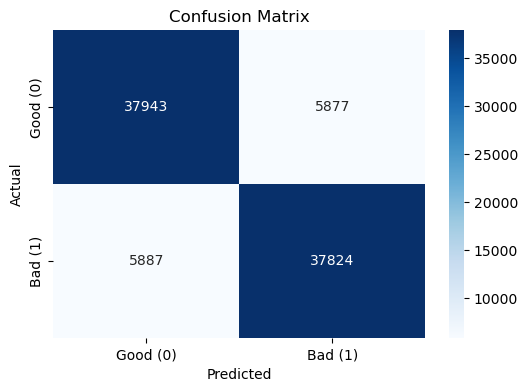

In [ ]:
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score

best_params = {
    'learning_rate': 0.09959803338908761,
    'num_leaves': 100,
    'max_depth': 20,
    'min_data_in_leaf': 81,
    'min_gain_to_split': 0.015222355161103074,
    'feature_fraction': 0.9536149400109485,
    'bagging_fraction': 0.9493976672327608,
    'bagging_freq': 1,
    'objective': 'binary',
    'metric': 'f1',
    'boosting_type': 'gbdt',
    'random_state': 42
}

model = lgb.LGBMClassifier(**best_params)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # probabilities for ROC-AUC

f1 = f1_score(y_test, y_pred)
print(f"\nF1 Score: {f1:.4f}")

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Good (0)", "Bad (1)"], yticklabels=["Good (0)", "Bad (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import joblib
joblib.dump(model, 'lightgbm_model.pkl')

['lightgbm_model.pkl']

## 3. Adaboost (Decision tree)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score

base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)

adb_clf = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=50,
    learning_rate=1.0,
    random_state=42
)

adb_clf.fit(X_train, y_train)
y_pred_adb = adb_clf.predict(X_test)
y_proba_adb = adb_clf.predict_proba(X_test)[:, 1]

print("AdaBoost Classification Report:")
print(classification_report(y_test, y_pred_adb))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_adb):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_adb):.4f}")

C:\Users\ansru\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.77     43820
           1       0.77      0.76      0.76     43711

    accuracy                           0.77     87531
   macro avg       0.77      0.77      0.77     87531
weighted avg       0.77      0.77      0.77     87531

ROC-AUC Score: 0.8590
F1 Score: 0.7648


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'estimator__max_depth': [1, 2, 3],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
}

base_tree = DecisionTreeClassifier(random_state=42)
adb_clf_tuned = AdaBoostClassifier(estimator=base_tree, random_state=42)

random_search_adb = RandomizedSearchCV(
    estimator=adb_clf_tuned,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1', 
    cv=5,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

random_search_adb.fit(X_train, y_train)

print("Best Parameters:", random_search_adb.best_params_)
print("Best F1 Score from CV:", random_search_adb.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\ansru\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best Parameters: {'n_estimators': 200, 'learning_rate': 0.5, 'estimator__min_samples_split': 5, 'estimator__min_samples_leaf': 2, 'estimator__max_depth': 3}
Best F1 Score from CV: 0.8455675165447409


AdaBoost (Tuned) - Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85     43820
           1       0.85      0.84      0.85     43711

    accuracy                           0.85     87531
   macro avg       0.85      0.85      0.85     87531
weighted avg       0.85      0.85      0.85     87531

ROC-AUC Score: 0.9312277457614665
F1 Score: 0.845100930961379


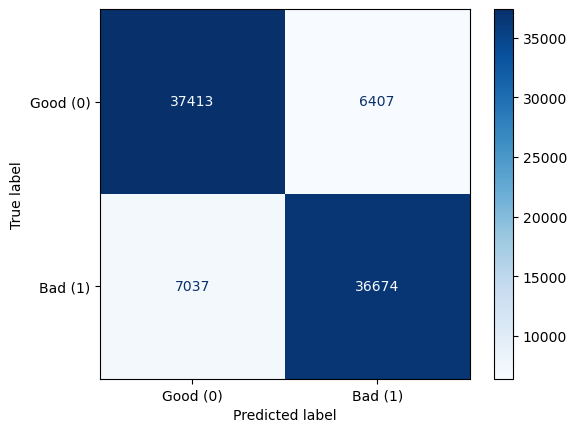

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_adb = random_search_adb.best_estimator_.predict(X_test)
y_proba_adb = random_search_adb.best_estimator_.predict_proba(X_test)[:, 1]

print("AdaBoost (Tuned) - Classification Report:")
print(classification_report(y_test, y_pred_adb))

print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_adb))
print("F1 Score:", f1_score(y_test, y_pred_adb))

# confusion matrix
cm = confusion_matrix(y_test, y_pred_adb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Good (0)", "Bad (1)"])
disp.plot(cmap="Blues", values_format="d")

In [ ]:
import joblib
joblib.dump(random_search_adb.best_estimator_, 'adaboost_tuned_model.pkl')

## 4. Logistic Regression

First I will evaluate the model without applying any kind of scaling onto the dataset and using default parameters.

C:\Users\ansru\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression (Default) - Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.71      0.70     43820
           1       0.70      0.68      0.69     43711

    accuracy                           0.70     87531
   macro avg       0.70      0.70      0.70     87531
weighted avg       0.70      0.70      0.70     87531

ROC-AUC Score: 0.8010641513272923
F1 Score: 0.6930002904443799


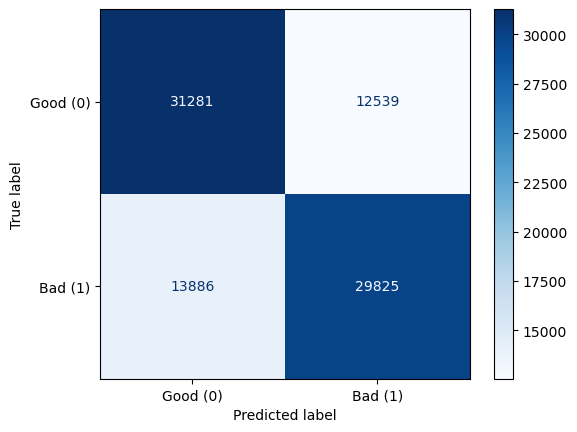

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]

print("Logistic Regression (Default) - Classification Report:")
print(classification_report(y_test, y_pred_lr))

print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr))

cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Good (0)", "Bad (1)"])
disp.plot(cmap="Blues", values_format="d")


We see that lbfgs failed to converge and the warning is advising to scale the dataset. I'll therefore apply scaling to the dataset in a careful manner.

In [ ]:
# check in both datasets
combined_X = pd.concat([X_train, X_test])

# for absence of -1
columns_without_minus1 = [col for col in combined_X.columns if (combined_X[col] != -1).all()]
print("Columns without -1 in any row (train + test):\n", columns_without_minus1)

Columns without -1 in any row (train + test):
 ['shannon_entropy', 'directory_length', 'has_dir', 'file_length', 'length_url', 'qty_dot_url', 'qty_slash_url', 'domain_length', 'qty_vowels_domain', 'has_file', 'qty_dot_domain', 'params_length', 'qty_hyphen_domain', 'qty_hyphen_url']


Let's first apply scaling to all these columns

Logistic Regression (Scaled Selected Features) - Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.71      0.70     43820
           1       0.70      0.68      0.69     43711

    accuracy                           0.70     87531
   macro avg       0.70      0.70      0.70     87531
weighted avg       0.70      0.70      0.70     87531

ROC-AUC Score: 0.8010754963822428
F1 Score: 0.6938472081866862


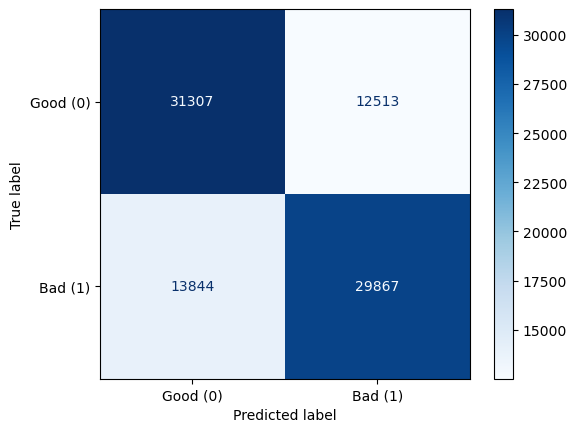

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import joblib

columns_to_scale = [
    'shannon_entropy', 'directory_length', 'file_length', 'length_url', 'qty_dot_url',
    'qty_slash_url', 'domain_length', 'qty_vowels_domain',
    'qty_dot_domain', 'params_length', 'qty_hyphen_domain', 'qty_hyphen_url'
]

scaler = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), columns_to_scale)
    ],
    remainder='passthrough'  # keep other columns the same
)

logreg_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

logreg_pipeline.fit(X_train, y_train)

y_pred_lr = logreg_pipeline.predict(X_test)
y_proba_lr = logreg_pipeline.predict_proba(X_test)[:, 1]

print("Logistic Regression (Scaled Selected Features) - Classification Report:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr))

cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Good (0)", "Bad (1)"])
disp.plot(cmap="Blues", values_format="d")

Now I will run RandomSearch for tuning the parameters.

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\ansru\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Parameters: {'classifier__tol': 0.0001, 'classifier__solver': 'saga', 'classifier__penalty': 'l2', 'classifier__max_iter': 1000, 'classifier__C': 11.288378916846883}
Best F1 Score from CV: 0.6990939614485318
Logistic Regression (Tuned) - Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.71      0.70     43820
           1       0.71      0.69      0.70     43711

    accuracy                           0.70     87531
   macro avg       0.70      0.70      0.70     87531
weighted avg       0.70      0.70      0.70     87531

ROC-AUC Score: 0.8010131146339685
F1 Score: 0.6980403937699311


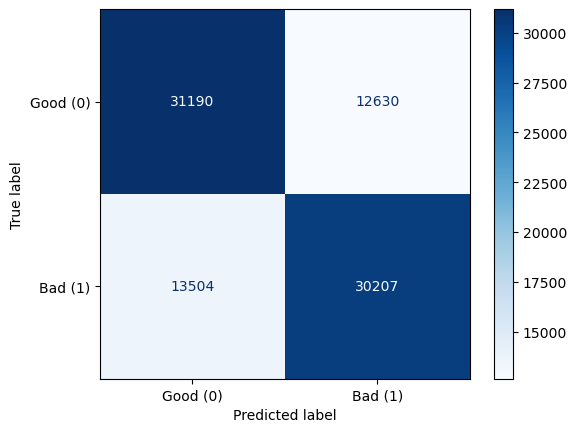

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

param_dist = {
    'classifier__C': np.logspace(-4, 4, 20),
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__max_iter': [500, 1000, 1500],
    'classifier__tol': [1e-4, 1e-3, 1e-2],
}

columns_to_scale = [
    'shannon_entropy', 'directory_length', 'file_length', 'length_url', 'qty_dot_url',
    'qty_slash_url', 'domain_length', 'qty_vowels_domain',
    'qty_dot_domain', 'params_length', 'qty_hyphen_domain', 'qty_hyphen_url'
]

scaler = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), columns_to_scale)
    ],
    remainder='passthrough'
)

logreg_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('classifier', LogisticRegression(random_state=42))
])

random_search = RandomizedSearchCV(
    estimator=logreg_pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=3
)

random_search.fit(X_train, y_train)

print(f"Best Parameters: {random_search.best_params_}")
print(f"Best F1 Score from CV: {random_search.best_score_}")

y_pred_lr = random_search.best_estimator_.predict(X_test)
y_proba_lr = random_search.best_estimator_.predict_proba(X_test)[:, 1]

print("Logistic Regression (Tuned) - Classification Report:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr))

cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Good (0)", "Bad (1)"])
disp.plot(cmap="Blues", values_format="d")

In [ ]:
joblib.dump(random_search.best_estimator_, 'logreg_tuned_pipeline.pkl')

['logreg_tuned_pipeline.pkl']

# RESULTS

In [ ]:
import pandas as pd

X_train = pd.read_csv('dataset/training_datasetDEF.csv')

df = pd.read_csv('dataset/train_label_column.csv')
# Convert "Label" column: "good" → 0, "bad" → 1
df["Label"] = df["Label"].map({"good": 0, "bad": 1})
y_train = df["Label"]

X_test = pd.read_csv('dataset/testing_revamped2.csv')
y_test_df = pd.read_csv('dataset/testing_labels.csv')
y_test = y_test_df["Label"]

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report, confusion_matrix
)
import numpy as np

def evaluate_model(model, X_test, y_test, model_name="Model"):
    
    y_pred = model.predict(X_test)
    
    try:
        y_proba = model.predict_proba(X_test)[:, 1]  # ROC-AUC
    except AttributeError:
        try:
            y_proba = model.decision_function(X_test) 
        except AttributeError:
            print("Model does not support probability or decision scores for ROC-AUC.")
            y_proba = None

    # metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else "N/A"

    print(f"Accuracy : {accuracy:.6f}")
    print(f"Precision: {precision:.6f}")
    print(f"Recall   : {recall:.6f}")
    print(f"F1 Score : {f1:.6f}")
    print(f"ROC-AUC  : {auc if isinstance(auc, str) else round(auc, 6)}")
    
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [ ]:
import joblib

rf_model = joblib.load("random_forest_model.joblib")
xgb_model = joblib.load("XGBoost_model.joblib")
lgbm_model = joblib.load("lightgbm_model.pkl")
adaboost_model = joblib.load("adaboost_tuned_model.pkl")

C:\Users\ansru\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\ansru\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\ansru\anaconda3\Lib\pickle.py:1759: UserWarning: [13:45:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\data\../common/error_msg.h:82: If you are loading a serialized model (

In [ ]:
evaluate_model(rf_model, X_test, y_test, "Random Forest")
evaluate_model(xgb_model, X_test, y_test, "XGBoost")
evaluate_model(lgbm_model, X_test, y_test, "LightGBM")
evaluate_model(adaboost_model, X_test, y_test, "AdaBoost")

Accuracy : 0.893809
Precision: 0.892966
Recall   : 0.894580
F1 Score : 0.893773
ROC-AUC  : 0.961211

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89     43820
           1       0.89      0.89      0.89     43711

    accuracy                           0.89     87531
   macro avg       0.89      0.89      0.89     87531
weighted avg       0.89      0.89      0.89     87531

Accuracy : 0.878820
Precision: 0.881840
Recall   : 0.874517
F1 Score : 0.878163
ROC-AUC  : 0.955111

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88     43820
           1       0.88      0.87      0.88     43711

    accuracy                           0.88     87531
   macro avg       0.88      0.88      0.88     87531
weighted avg       0.88      0.88      0.88     87531

[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current v